# Classifiez automatiquement des biens de consommation

- **Projet 6 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 2 : Classification des images


<!--TABLE OF CONTENTS-->

Contents:

- [1. Compréhension du problème](#1.-Compréhension-du-problème)
  - [1.1 Mission](#1.1-Mission)
  - [1.2 Requirements : Bibliothèques utilisées dans ce notebook](#1.2-Requirements-:-Bibliothèques-utilisées-dans-ce-notebook)
  - [1.3 Des fonctions utilitaires](#1.3-Des-fonctions-utilitaires)
- [2. Import, nettoyage et analyse exploratoire des données](#2.-Import,-nettoyage-et-analyse-exploratoire-des-données)
  - [2.1 Import des données textes pour récuperer les images](#2.1-Import-des-données-textes-pour-récuperer-les-images)
  - [2.1 Import des images (lecture)](<#2.1-Import-des-images-(lecture)>)
  - [2.2 Nettoyage des données](#2.2-Nettoyage-des-données)
  - [3.1 Préparation des catégories](#3.1-Préparation-des-catégories)
  - [Enregistre les données préparées](#Enregistre-les-données-préparées)
  - [Nettoyage des variables globales](#Nettoyage-des-variables-globales)
- [4. Fonctions communs pour modèles classification](#4.-Fonctions-communs-pour-modèles-classification)
  - [4.1 Lecture des données](#4.1-Lecture-des-données)
  - [4.2 Modélisation et évaluation des modèles:](#4.2-Modélisation-et-évaluation-des-modèles:)
  - [4.3 Visualisations de metriques de performance](#4.3-Visualisations-de-metriques-de-performance)
  - [4.4 Visualisation des clusters sur les 'reduced_dimensions'](#4.4-Visualisation-des-clusters-sur-les-'reduced_dimensions')
- [9. Enregistrement des résultats](#9.-Enregistrement-des-résultats)


# 1. Compréhension du problème

## 1.1 Mission

Etudier la faisabilité d'un **moteur de classification** des articles en différentes catégories,
avec un niveau de précision suffisant.

- **réaliser une première étude de faisabilité d'un moteur de classification**, d'articles, basé sur
  une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

- **analyser le jeu de données** en **réalisant un prétraitement** des descriptions des produits et
  des images, une **réduction de dimension**, puis un **clustering**, à présenter sous la forme de
  graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories
  réelles et les clusters.
- illustre que les caractéristiques extraites permettent de regrouper des produits de même
  catégorie.

- démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des
  produits de même catégorie


### 1.1.1 Interprétation

Etapes pour la classification d'images :

- prétraitement des images
- extraction des _features_ (SIFT, ORB)
- création des _bag-of-features_
- classification supervisée (par CNN par exemple)


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook

**Installation d'openCV sur windows**

- Utilise la commande `pip install opencv-contrib-python` dans votre environnement conda
- test : `import cv2; print(cv2.__version__)`
- <https://learnopencv.com/install-opencv-on-windows/>


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# decommentarise la ligne suivant pour des versions testées:

# %pip install -r requirements.txt


In [2]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas',
                      'matplotlib', 'seaborn', 'scikit-learn',
                      'pillow', 'pydot', 'graphviz', 'pathvalidate', 'plotly'}
install_libraries(required_libraries)


### 1.2.1 Import des bibliothèques

les bibliothèques keras et tensorflow.keras sont 2 bibliothèques distinct, parfois avec des subtil differences entre les apis.

Pour éviter des problèmes, [il es recommandé](https://pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/) d'importer keras seulement de tensorflow.


In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import time
import random  # for sampling np.array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# optimize linear sum du diagonal d'un confusion matrix
import scipy

import sklearn

# feature preprocessing
from sklearn import preprocessing
# feature et parameter selection
from sklearn.model_selection import train_test_split, ParameterGrid
# reduction de dimensions TSNE et PCA
from sklearn import manifold, decomposition
# clustering KMeans
from sklearn import cluster
# metrics de performance
from sklearn import metrics

import PIL  # constants
# lecture, conversion, enregistrement d'un image
from PIL import Image
# mise en gris, egalize, resize, filtre...
from PIL import ImageOps, ImageFilter

# Bibliothèque de computer vision
import cv2

# pour diagrammes Sankey
import plotly.graph_objects as go
from IPython import display
import plotly.io as pio
# pour enregistre diagramme Sankey comme png
import kaleido

# Enregistre les 
import pickle

import tensorflow as tf
from tensorflow import keras

# pour visualiser les keras models comme diagramme
import pydot
import graphviz

# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16


### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

print(python_version())
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


3.7.0
versions des bibliothèques utilisées:
numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; scipy==1.7.3; sklearn==1.0.2; PIL==8.4.0; PIL.Image==8.4.0; cv2==4.5.5; kaleido==0.2.1; tensorflow==2.8.0; keras.api._v2.keras==2.8.0; pydot==1.4.2; graphviz==0.20


### 1.2.3 Configuration défauts d'affichage


In [5]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 100)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

sklearn.set_config(display='diagram')
# displays HTML representation in a jupyter context


### 1.2.4 Quelques constants


In [6]:
# Definir RANDOM_SEED = None pour des résultats variables
# Ici on définit RANDOM_SEED = constant seulement pour réproducibilité
RANDOM_SEED = 42

# Suppression du PIL DecompressionBombWarning, car un image est 93680328 pixels
# Image size (pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
# PIL.Image.MAX_IMAGE_PIXELS = 89478485 (default)
PIL.Image.MAX_IMAGE_PIXELS = 93680328 + 1


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [7]:
SAVE_IMAGES = True
IMAGE_FOLDER = 'images/cv'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [8]:
def sanitize(fig_name: str) -> str:
    """Enleve les caractères interdits dans les filenames ou filepaths"""
    return fig_name.replace(' ', '_').replace(':', '-').replace(
        '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')


def make_timestamp():
    return time.strftime('%Y-%m-%d_%H_%M_%S')


def to_png(fig_name=None) -> None:
    """
    Register the current plot figure as an image in a file.
    Must call plt.show() or show image (by calling to_png() as last row in python cell)
    to apply the call 'bbox_inches=tight', to be sure to include the whole title / legend
    in the plot area.
    """

    def get_title() -> str:
        """find current plot title (or suptitle if more than one plot)"""
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = sanitize(fig_name)
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


In [9]:
OUT_FOLDER = 'data/out'


def save_pickle(obj, filename, filepath=OUT_FOLDER):
    with open(f'{filepath}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_pickle(filename, filepath=OUT_FOLDER):
    with open(f'{filepath}/{filename}.pickle', 'rb') as handle:
        return pickle.load(handle)


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [10]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """
    Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


## 1.4 Evaluation des modèles:

- **Réduction de dimensions** (par t-SNE, PCA, NMF, truncatedSVD...)

- **Classification (clustering) non-supervisée sur les dimensions réduits** (Gridsearch des hyperparamètres, sans ou avec choix de nombre de clusters)

  - par Kmeans (défaut)
  - par LDA (topic modelling)
  - par NMF (pas utilisé ici)

- **Evaluation de performance**:

  - distortion score (l'inertie ou somme d'erreurs carrés de chaque cluster)
  - score davies_bouldin (mésure de séparation des clusters)
  - score silhouette des clusters (+ visualisation des silhouettes de chaque cluster)
  - score stabilité des clusters (sur des sous-échantillons --> écart type)

- **Evaluation de correspondance avec les catégories définis**
  - ARI score
  - pourcentage des items mal classés
  - visualisation pour comparer les clusters sur les principaux dimensions réduits (TSNE ou PCA par exemple)
  - visualisation Sankey de correlations entre clusters


### 1.4.1 Scoring : performance d'un model KMeans

Un alternative a GridsearchCV, qui permet d'evaluer plusieurs métriques


In [11]:
# from sklearn.model_selection import ParameterGrid
# from sklearn import model, cluster, metrics
import time

search_params = {'n_clusters': range(4, 12)}


def get_classname(estimator):
    return estimator.__class__.__name__


def score_kmeans(df: pd.DataFrame, param_grid=search_params, labels_true=None):
    """Executer un traitement de données, extraire les features, réduire les dimensions, et faire du clustering
    Returns : scores, labels du meilleur kmeans 
    """

    df_scores = pd.DataFrame({})

    nb_clusters = 7
    # generate parameter grid for classifier
    param_sets = ParameterGrid(param_grid)
    for params in param_sets:
        # print(f'score model for params = {params}')
        # set model parameters (usually just n_clusters for classifier)
        k = params.get('n_clusters', nb_clusters)
        clusterer = cluster.KMeans(n_clusters=k)
        clusterer.set_params(**params)
        #
        start_fit_clf = time.time()
        clusterer.fit(df)
        fit_time_clf = round(time.time()-start_fit_clf, 2)
        # print(f'Clusterer fit time = {fit_time_clf} s')

        labels_pred = clusterer.labels_
        cluster_sizes = (pd.Series(labels_pred).value_counts(
            normalize=True).values*100).astype(int)

        min_cluster_pct = pd.Series(
            labels_pred).value_counts(normalize=True).min()
        res = {'k': k,
               'min_cluster_pct': round(min_cluster_pct*100, 2),
               'distortion_score': round(getattr(clusterer, 'inertia_', 0), 0),
               'davies_bouldin': round(metrics.davies_bouldin_score(df, labels_pred), 2),
               'calinski_harabasz': round(metrics.calinski_harabasz_score(df, labels_pred), 2),
               'silhouette_score': round(metrics.silhouette_score(df, labels_pred), 3),
               'fit_time_cluster': fit_time_clf
               }
        ARI = ''
        if not labels_true is None:
            res['ARI'] = round(metrics.adjusted_rand_score(
                labels_true, labels_pred), 3)
            ARI = f" ARI = {res['ARI']},"
        print(
            f"k={k}, fit: {fit_time_clf} s, silhouette= {res['silhouette_score']:.3},{ARI} cluster sizes = {cluster_sizes}")
        df_scores = df_scores.append(res, ignore_index=True)

    df_scores['classifier'] = get_classname(clusterer)
    df_scores['k'] = df_scores['k'].astype(int)

    # fourni les labels du meilleur k (on peut plus inferer best_k = labels.nunique())
    best_score_idx = df_scores['silhouette_score'].idxmax()
    best_k = df_scores.loc[best_score_idx, 'k']
    clusterer = cluster.KMeans(n_clusters=best_k)
    clusterer.fit(df)
    labels_pred = clusterer.labels_
    return df_scores, labels_pred


## 4.3 Visualisations de metriques de performance

On s'inspire de yellowbrick KElbowVisualizer pour generaliser à d'autres metriques (stability par exemple)


In [12]:

def angle_between_vectors(v1, v2):
    """
    calculate angle between 2 vectors.
    use to find elbows
    """
    ang1 = np.arctan2(*v1[::-1])
    ang2 = np.arctan2(*v2[::-1])
    ang = np.rad2deg(abs(ang1 - ang2) % (2 * np.pi))
    if ang > 180:
        ang = ang-180
    return ang


print([
    angle_between_vectors([1, 1], [0, 0]),
    angle_between_vectors([1, 1], [0, 1]),
    angle_between_vectors([1, 1], [-1, 0]),
    angle_between_vectors([1, 1], [-1, -1]),
])


[45.0, 45.0, 135.0, 180.0]


In [13]:

def find_elbow(df: pd.DataFrame, x_col='k', y_col='distortion_score'):
    """find sharpest difference in angle for [k, score]"""
    df = df.copy().reset_index()
    # standardise scale to maximise angles between points

    x_scale = df[x_col].max()-df[x_col].min()
    y_min = df[y_col].min()
    y_mult = (df[y_col].max()-y_min)/x_scale
    df['y_scaled'] = (df[y_col]-y_min)/y_mult

    # calculate angles between consecutive points
    n = len(df)
    for i in range(0, n-2):
        point1 = df.loc[i, [x_col, 'y_scaled']]
        point2 = df.loc[i+1, [x_col, 'y_scaled']]
        point3 = df.loc[i+2, [x_col, 'y_scaled']]
        vec1 = point2-point1
        vec2 = point3-point2
        df.loc[i+1, 'angle'] = angle_between_vectors(vec1, vec2)
    # elbow is at highest difference in angle (assume monotonic function)
    row = df['angle'].idxmax()
    x_elbow = df.loc[row, x_col]
    y_score = df.loc[row, y_col]
    return x_elbow, y_score


In [14]:

# k_best, distortion_score = find_elbow(scores, y_col='distortion_score')
# print(f'Best score for k = {k_best}')
# # check labels for best score have been returned
# print(pd.Series(labels).nunique())


### 4.3.1 Plot elbow visualiser


In [15]:

def plot_second_ax(df, x_col, y2_col, ax, color='grey'):
    """add a secondary y axis to a plot"""
    if y2_col in df.columns:
        ax2 = ax.twinx()
        ax2.plot(df[x_col], df[y2_col], label=y2_col,
                 c=color, marker='o', linestyle='--', alpha=0.75)
        ax2.tick_params(axis='y', colors=color)
        ax2.set_ylabel(y2_col, color=color)


def plot_elbow(df, x_col, y_col, ax):
    """draw a vertical line at elbow on a plot"""
    elbow_k, elbow_score = find_elbow(df, x_col, y_col)
    elbow_label = f'elbow at ${x_col}={elbow_k}$'
    ax.axvline(elbow_k, c='k', linestyle="--", label=elbow_label)
    ax.legend(frameon=True)


def plot_vline(df, x_col, y_col, ax, line_at='max'):
    """draw a vertical line at max or min value of y on a plot"""
    if line_at == 'max':
        row_idx = df[y_col].argmax()
    elif line_at == 'min':
        row_idx = df[y_col].argmin()
    line_x = df.loc[row_idx, x_col]
    line_label = f'{line_at} at ${x_col}={line_x}$'
    ax.axvline(line_x, c='k', linestyle="--", label=line_label)
    ax.legend(frameon=True)


def plot_elbow_visualiser(df: pd.DataFrame, x_col='k', score_col='distortion_score',
                          show_elbow=False, time_col=None, ax1=None):
    """
    Generic ElbowVisualiser, capable of showing any metric, elbows, secondary axis...
    Allows subsequent manipulation of plots
    """
    colors = sns.color_palette("tab20").as_hex()
    if ax1 is None:
        _, ax1 = plt.subplots()
    # scores
    ax1.plot(df[x_col], df[score_col],
             marker="D", c=colors[0], linestyle="-")
    ax1.grid(False)
    ax1.tick_params(axis='y', colors=colors[0])
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(score_col, c=colors[0])
    # fit times
    if not time_col is None:
        plot_second_ax(df, x_col, y2_col=time_col, ax=ax1)
    if show_elbow:
        plot_elbow(df, x_col, score_col, ax1)


# Test visualiser
# plot_elbow_visualiser(scores, score_col='distortion_score', show_elbow=True)
# plt.suptitle(f'Kmeans Distortion Score')
# to_png()


### 4.3.2 Plot summary metrics

- visualiser plusieurs metriques com subplots


In [16]:
# print(sorted(list(scores.columns)))


In [17]:

def plot_metrics(df_scores, x_col='k', titre=''):
    """
    Plot each clustering metric in df_scores in a subplot
    Plots to show depend on metrics added to df_scores
    Parameters
    ----------
    df_scores   Scores for all permutations of a param_grid (previously calculated)
    x_col       Choice of parameter to compare -by default k, but can show any hyperparameter
    """
    if 'clf' in df_scores.columns and 'preprocessor' in df_scores.columns:
        print(
            f"plotting metrics (clf: {df_scores['clf'][0]}, preprocessor: {df_scores['preprocessor'][0]})")

    METRICS = ['distortion_score', 'calinski_harabasz',
               'davies_bouldin', 'silhouette_score', 'stability_score']
    metrics = cols_in_df(df_scores, METRICS)
    n_plots = len(metrics)
    n_cols = min(n_plots, 2)
    # n_rows = int(ceil(n_plots/n_cols))
    n_rows = n_plots // n_cols + (n_plots % n_cols > 0)
    _ = plt.figure(figsize=(n_cols*5, n_rows*3))
    for n, metric in enumerate(metrics):
        ax = plt.subplot(n_rows, n_cols, n + 1)
        if metric == 'distortion_score':
            plot_elbow_visualiser(
                df_scores, x_col, metric, ax1=ax, time_col='fit time (s)', show_elbow=True)
            plt.title(metric)
        if metric == 'calinski_harabasz':
            plot_elbow_visualiser(df_scores, x_col, metric, ax1=ax)
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(f'{metric} score (max={df_scores[metric].max():.0f})')
        if metric == 'davies_bouldin':
            plot_elbow_visualiser(df_scores, x_col, metric, ax1=ax)
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='min')
            plt.title(f'{metric} score (min={df_scores[metric].min():.2f})')
        if metric == 'silhouette_score':
            titre = f'{metric} (max={df_scores[metric].max():.2f})'
            if 'silhouette_score_std' in df_scores.columns:
                if 'silhouette_sample_sizes' in df_scores.columns:
                    sample_size = int(
                        df_scores['silhouette_sample_sizes'].max())
                    titre += f' 10 samples de {sample_size} pts'
                plt.errorbar(data=df_scores, x=x_col, y='silhouette_score',
                             yerr='silhouette_score_std')
            plot_elbow_visualiser(df_scores, x_col, metric,
                                  ax1=ax, time_col='silhouette_time')
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(titre)
        if metric == 'stability_score':
            titre = f'{metric} (max={df_scores[metric].max():.2f})'
            if 'stability_score_std' in df_scores.columns:
                if 'stability_sample_sizes' in df_scores.columns:
                    sample_size = int(
                        df_scores['stability_sample_sizes'].max())
                    titre += f' 10 samples de {sample_size} pts'
                plt.errorbar(data=df_scores, x=x_col, y='stability_score',
                             yerr='stability_score_std')
            plot_elbow_visualiser(df_scores, x_col, metric,
                                  ax1=ax, time_col='stability_time')
            plot_vline(df_scores, x_col, metric, ax=ax, line_at='max')
            plt.title(titre)

    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.suptitle(
        f"Plot metrics - {titre}")


# test
# plot_metrics(scores)
# to_png()


## 4.4 Visualisation des clusters sur les 'reduced_dimensions'


### 4.4.1 Calcul de meilleur correspondance entre categorie et cluster label

Les cluster labels attribué par des modélisations (ex: kmeans) sont aléatoires, que fait que des comparaisons entre la catégorie atribuée et les libellés sont difficil a comparer : ils n'ont pas les même couleurs

On essaie de faire correspondre les cluster labels dans la même ordre que categ_true,
pour faciliter : - la matrice de confusion entre categorie et cluster - la comparaison des clusters sur plots tsne/pca (couleurs plus proche) - les diagrammes Sankey pour montre les rélations

- https://sparse-plex.readthedocs.io/en/latest/book/clustering/comparing_clusterings.html
- https://python.plainenglish.io/hungarian-algorithm-introduction-python-implementation-93e7c0890e15
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html

Comme alternative à KMeans (algorithme publié octobre 2021):

- https://www.researchgate.net/publication/353696146_The_utility_of_clusters_and_a_Hungarian_clustering_algorithm


In [18]:
def squarify_df(df: pd.DataFrame, val=0):
    rows, cols = df.shape
    if rows > cols:
        # append columns to end of dataframe
        pad_cols = rows-cols
        pad_df = pd.DataFrame(
            np.zeros((rows, pad_cols), dtype=int), index=df.index)
        pad_df.columns = [f'pad_{i}'for i in range(pad_cols)]
        df = df.join(pad_df)
    elif cols > rows:
        # append rows to end of dataframe
        pad_rows = cols-rows
        pad_df = pd.DataFrame(data=np.zeros((cols-rows, cols), dtype=int),
                              columns=range(cols))
        pad_df.index = [f'pad_{i}'for i in range(pad_rows)]
        df = df.append(pad_df)
    return df


df_test_rows = pd.DataFrame([[1, 0, 6], [0, 3, 3]])
df_test_cols = df_test_rows.T
print(df_test_rows.shape)
print(squarify_df(df_test_rows))
print(squarify_df(df_test_cols))


(2, 3)
       0  1  2
0      1  0  6
1      0  3  3
pad_0  0  0  0
   0  1  pad_0
0  1  0      0
1  0  3      0
2  6  3      0


In [19]:
def conf_matrix_labels(categ_true: pd.Series, clust_labels: pd.Series, normalize=False):
    """
    Calcul de meilleur correspondance entre true_categorie et predicted categorie

    Les cluster labels attribué par kmeans sont aléatoires
    On essaie de mettre les cluster labels dans la même ordre que categ_true, 
    pour faciliter :
        - la matrice de confusion entre categorie et cluster
        - la comparaison des clusters sur plots tsne/pca (couleurs plus proche)
        - les diagrammes Sankey pour montre les rélations 
    """
    if isinstance(categ_true, pd.Series):
        if isinstance(clust_labels, pd.Series):
            # si les deux sont des series, pd.crosstab utilise leur indices pour faire le crosstab
            clust_labels = clust_labels.copy()
            clust_labels.index = categ_true.index

    # créer le matrice de confusion entre categorie et cluster label
    df_matr: pd.DataFrame = pd.crosstab(categ_true, clust_labels,
                                        normalize=normalize)

    # Si besoin, créer un matrice carré pour pouvoir applique l'algorithme
    n_categ = df_matr.shape[0]
    n_labels = df_matr.shape[1]

    square_matr = squarify_df(df_matr).fillna(0)

    # trouve ordre de colonnes et lignes pour maximiser valeurs dans le diagonale
    rows, cols = scipy.optimize.linear_sum_assignment(
        square_matr.values, maximize=True)

    if len(rows) > n_categ:
        rows = [idx for idx in rows if idx < n_categ]
    if len(cols) > n_labels:
        cols = [idx for idx in cols if idx < n_labels]
    # print(f'len(rows) : {len(rows)}')
    # print(f'len(cols) : {len(cols)}')
    df_opt = df_matr.iloc[:, cols]

    new_cols = [str(col) for col in df_opt.index]
    cluster_labelmap = dict(zip(list(df_opt.columns), new_cols))

    if normalize == False:
        df_opt = df_opt.round(0).astype(int)

    return df_opt, cluster_labelmap


# str_labels = pd.Series(labels).map(lambda x: f'cluster_{x}')
# conf_matrix_labels(categ_true=y_cat_txt,
#                    clust_labels=pd.Series(labels, dtype=str))


### 4.4.2 Clustering KMeans via TSNE, et calcul de metric ARI

Un fois les scores sont calculés, les procédures ci-dessous permet de visualiser


In [20]:
# from sklearn import decomposition
def reducer_pca(features: pd.Series, n_components=0.99) -> np.ndarray:
    """Reduction de dimensions pour rester avec [99%] de la variance expliqué"""
    percent_var = '' if n_components >= 1 else f' ({n_components*100:.0f} % variance explained) '
    print(f'Dimensions avant réduction PCA {percent_var} : { features.shape}')
    pca = decomposition.PCA(n_components=n_components)
    feat_pca = pca.fit_transform(features)
    print("Dimensions après réduction PCA : ", feat_pca.shape)
    return feat_pca


In [21]:
# from sklearn import manifold
import time


def reducer_tsne(features: pd.Series) -> np.ndarray:
    """
    reduction de dimensions par t-SNE
    Parameters
    ---------
    features  numpy array, pd.Series or pd.DataFrame of shape[m,n]

    Returns
    ---------
    numpy array of shape[m,2]
    """
    time1 = time.time()
    tsne_model = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                               init='random', learning_rate=200, random_state=RANDOM_SEED)
    X_tsne = tsne_model.fit_transform(features)
    time2 = np.round(time.time() - time1, 0)
    print(f'reducer t-SNE, shape ={X_tsne.shape} time : {time2}')
    return X_tsne


In [22]:
# from sklearn import cluster, metrics
import time


def calc_ARI(labels_pred, labels_true):
    """Calcul l'Adjusted Rand Index score"""
    return np.round(metrics.adjusted_rand_score(labels_true, labels_pred), 4)


def calc_tsne_cluster(features, categories_, y_cat_num_, k=None):
    """
    Calcul Tsne, détermination des clusters et calcul ARI 
    entre vrais catégorie et n° de clusters
    Parameters
    ----------
    features  les feature vectors, peut-etre deja réduit en dimension par PCA
    categories  les libellés unique des y_true (utilisé seulement pour calculer k si ce n'est pas fourni)
    y_cat_num   les 'vraie' labels (y_true)
    k    le nombre de clusters à calculer

    Returns
    -------
    ARI  si y_cat_num est fourni (-1 sinon)
    X_tsne  les premier 2 composants TSNE (independent de k)
    labels  les cluster.labels_ fitted par KMeans pour k clusters
    """
    X_tsne = reducer_tsne(features)

    if k is None or not k > 0:
        k = len(categories_)

    time1 = time.time()
    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=k, n_init=100,
                         random_state=RANDOM_SEED)
    cls.fit(X_tsne)
    time2 = np.round(time.time() - time1, 0)
    if len(y_cat_num_) == len(cls.labels_):
        ARI = np.round(metrics.adjusted_rand_score(y_cat_num_, cls.labels_), 4)
        print("ARI : ", ARI, "time : ", time2)
    else:
        ARI = -1
        print('ARI ne peut pas être calculé : len(y_true) != len(y_pred)')

    # ajout cls.cluster_centers_ ?
    return ARI, X_tsne, cls.labels_


### 4.2.2 Visualisation des clusters sur les dimensions réduits


In [23]:

#
def plot_clusters_sur_2D(X_tsne_, y_cat_num_, labels_, ARI_,
                         bbox_left=-0.05, loc=1,
                         palette='bright',
                         titre1='Représentation des produits par catégories réelles',
                         titre2='Représentation des produits par clusters'):
    """
    Visualisation du Tsne selon les vraies catégories et selon les clusters
    """
    if ARI_ is None:
        ARI_ = calc_ARI(y_cat_num_, labels_)
    df_opt, label_map = conf_matrix_labels(y_cat_num_, labels_)

    # s_labels=pd.Series(labels_).map(label_map)
    s_labels = pd.Series(labels_)

    # mettre l'ordre des clusters dans la même ordre que les y_cat
    labels_hue_order = list(df_opt.columns)
    n_labels = len(labels_hue_order)

    categ_hue_order = sorted(list(pd.Series(y_cat_num_).unique()))
    n_categ = len(categ_hue_order)

    n_max = max(n_labels, n_categ)
    colors = sns.color_palette(palette, n_colors=n_max)
    # print (colors)
    labels_palette = colors[:n_labels]
    categ_palette = colors[:n_categ]
    fig = plt.figure(figsize=(15, 6))

    ax1 = fig.add_subplot(121)
    scatter1 = sns.scatterplot(x=X_tsne_[:, 0], y=X_tsne_[:, 1], ax=ax1,
                               hue=y_cat_num_, hue_order=categ_hue_order, palette=categ_palette)
    ax1.legend(title="Categorie", bbox_to_anchor=(bbox_left, 0.5), loc=loc)
    plt.title(titre1)

    ax2 = fig.add_subplot(122)
    scatter2 = sns.scatterplot(x=X_tsne_[:, 0], y=X_tsne_[:, 1], ax=ax2,
                               hue=s_labels, hue_order=labels_hue_order, palette=labels_palette)
    ax2.legend(loc="best", title="Clusters")
    plt.title(titre2)
    print("ARI : ", ARI_)
    return fig


### Calcul des clusters et affichage


In [24]:
# scores1, labels1, X_tsne1 = score_model(data_T, labels_true=y_cat_txt,
#                                        feature_extractor=CountVectorizer(
#                                            stop_words='english', ngram_range=(1, 1), max_df=0.95, min_df=3),
#                                        dimension_reducer=TSNE(n_components=2, perplexity=30, n_iter=2000,
#                                        init='random', learning_rate='auto'),
#                                        kmin=4, kmax=12)
# plot_metrics(scores1)


### Visualisation de confusion matrix comme une diagrame Sankey


In [25]:
# import plotly.graph_objects as go
# from IPython import display
# import plotly.io as pio


def add_alpha(color, alpha):
    (r, g, b) = color
    return f'rgba({r},{g},{b},{alpha})'


def plot_sankey_confusion_diagram(source: pd.Series, target: pd.Series = None,
                                  titre='Sankey confusion diagram',
                                  descriptors=['categories', 'clusters'],
                                  figsize=(2, 1), font_size=14,
                                  to_image=True,
                                  palette='nipy_spectral', alpha=0.5):
    """
    Plot confusion matrix as a Sankey diagram
    Accepts data in form of :
    - two series / lists (series names used as descriptors)
    - confusion matrix as a pandas dataframe (axes names used as descriptors)
    - confusion matrix as a numpy array (use parameter descriptors for source and target)

    Requires plotly,kaleido
    """
    # on peut fournir deux series (y_true, y_pred),
    if isinstance(source, pd.DataFrame) or len(source) < 10:
        ct = source.copy()
        if isinstance(ct, np.ndarray):
            print('ct is numpy array')
            ct = pd.DataFrame(ct)
            ct = ct.rename_axis(descriptors[0], axis=0)
            ct = ct.rename_axis(descriptors[1], axis=1)
    else:
        if isinstance(source, np.ndarray):
            source = pd.Series(source, name=descriptors[0])
        if isinstance(target, np.ndarray):
            target = pd.Series(target, name=descriptors[1])
        ct = pd.crosstab(source, target)

    source_col = ct.index.name if ct.index.name else descriptors[0]
    target_col = ct.T.index.name if ct.T.index.name else descriptors[1]
    print(source_col, target_col)

    ct.index = ct.index.astype(str)
    ct.columns = ct.columns.astype(str)

    # replace source and target labels with unique node_ids
    node_labels = list(ct.index)+list(ct.columns)
    node_ids = range(len(node_labels))
    label_map = dict(zip(node_ids, node_labels))

    # create colors for unique nodes (nodes with same name have same color)
    # uniq_nodes = sorted(list(set(node_labels)))
    uniq_nodes = []
    for node in node_labels:
        if not node in uniq_nodes:
            uniq_nodes.append(node)
    colors = sns.color_palette(palette, n_colors=len(uniq_nodes))
    solid_color_map = dict(zip(uniq_nodes, colors.as_hex()))
    node_colors = list(pd.Series(node_labels).map(solid_color_map))

    # create semi-transparent colors for links (link color same as source node)
    alpha_colors = list([add_alpha(color, alpha) for color in colors])
    alpha_color_map = dict(zip(uniq_nodes, alpha_colors))

    # map (possibly duplicate) node_labels to unique node_ids

    ct.index = node_ids[:len(ct.index)]
    ct.index.name = source_col
    ct.columns = node_ids[-len(ct.columns):]

    # create [source,target,value,color] matrix for links
    data = pd.melt(ct.reset_index(), id_vars=source_col)
    print(data.shape)
    print(data.columns)
    data.columns = [source_col, target_col, 'value']
    data = data[data['value'] > 0]
    data['src_color'] = data[source_col].map(label_map).map(alpha_color_map)

    # send data to plotly figure
    fig = go.Figure(data=[
        go.Sankey(node=dict(label=node_labels, color=node_colors),
                  link=dict(source=data[source_col], target=data[target_col],
                    value=data['value'], color=data['src_color'])
                  )
    ])

    titre = f'{titre} : {source_col} vs. {target_col}'
    fig.update_layout(title_text=titre, title_x=0.5, font_size=font_size)

    if to_image:
        # requires package 'kaleido'
        w, h = figsize
        fig_name = sanitize(titre)
        filename = f'{IMAGE_FOLDER}/{fig_name}.png'
        pio.write_image(fig, file=filename, format="png")
        # pio.write_image(fig, file=filename, format="png", width=w*300, height=h*300, scale=1)
        img = fig.to_image(format="png", width=w, height=h, scale=1)
        # from IPython import display
        return display.Image(img)
    else:
        fig.show()


# 2. Import, nettoyage et analyse exploratoire des données

Un premier jeu de données d’articles avec la photo et une description associée :
[le lien pour télécharger](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip)

Un fois téléchargé, les données du fichier zip (329 Mo) sont éxtraites dans le dossier définit par DATA_FOLDER ci-dessous.


In [26]:
ENV = 'local'

if ENV == 'local':
    # local development
    DATA_FOLDER = 'data/raw'
    OUT_FOLDER = 'data/out'
    IMAGE_FOLDER = 'images/cv'

if ENV == 'colab':
    # Colaboratory - uncomment les 2 lignes suivant pour connecter à votre drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    DATA_FOLDER = '/content/drive/MyDrive/data/OC6'
    OUT_FOLDER = '/content/drive/MyDrive/data/OC6'
    IMAGE_FOLDER = '/content/drive/MyDrive/images/OC6/cv'


In [27]:
# Données (DATA_FOLDER)
ZIPPED_DATA_FILENAME = f'Dataset+projet+prétraitement+textes+images.zip'
RAW_DATA_FILENAME = 'Flipkart/flipkart_com-ecommerce_sample_1050.csv'


def os_make_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def os_path_join(folder, file):
    """remplacement pour `os.path.join(folder, file)` sur windows"""
    return f'{folder}/{file}'


os_make_dir(IMAGE_FOLDER)
RAW_DATA = os_path_join(DATA_FOLDER, RAW_DATA_FILENAME)
DATA_ZIPPED = os_path_join(DATA_FOLDER, ZIPPED_DATA_FILENAME)
print(f'data file: {RAW_DATA}')


data file: data/raw/Flipkart/flipkart_com-ecommerce_sample_1050.csv


In [28]:
def unzip_data_si_besoin(env=ENV):
    """
    procedure pour unzip sur Google Drive via Google Colab
    """
    if os.path.exists(RAW_DATA):
        print(f'data CSV file exists ({RAW_DATA})')
    else:
        print(f'data CSV file does not exist ({RAW_DATA})')
        if env == 'colab' and os.path.exists(DATA_ZIPPED):
            # uncomment les 3 lignes suivants
            print(f'unzipping {DATA_ZIPPED}')
            !unzip {DATA_ZIPPED} - d {DATA_FOLDER}
            print(f'{DATA_ZIPPED} has been unzipped')
            if os.path.exists(RAW_DATA):
                print(f'data CSV file now exists ({RAW_DATA})')
        else:
            print(f'zipped data does not exist ({DATA_ZIPPED})')


unzip_data_si_besoin(ENV)


data CSV file exists (data/raw/Flipkart/flipkart_com-ecommerce_sample_1050.csv)


## 2.1 Import des données textes pour récuperer les images

Les données textes sont traités dans Partie 1.

On récrée les colonnes de catégories, puis supprime les colonnes pas utiles pour classification


In [29]:
df_data = pd.read_csv(RAW_DATA, sep=',', header=0, encoding='UTF-8')
print(list(df_data.columns))


['uniq_id', 'crawl_timestamp', 'product_url', 'product_name', 'product_category_tree', 'pid', 'retail_price', 'discounted_price', 'image', 'is_FK_Advantage_product', 'description', 'product_rating', 'overall_rating', 'brand', 'product_specifications']


### 2.1.1 Préparation des catégories

Features à créer à partir du `product_category_tree` :

- `categ_level_1` : les catégories à la racine de l'arbre
- `categ_level_2` : les sous-catégories (divisions dans `categ_level_1`)
- `categ_level_3` : les mini-catégories (divisions dans `categ_level_2`)


In [30]:
def create_categ_level(df, max_depth=3):
    if not 'product_category_tree' in df.columns:
        return df
    else:
        df_cat = (df_data['product_category_tree']
                  .str.lstrip('["').str.rstrip('"]').str.split(' >>', expand=True))
        df_cat = df_cat[df_cat.columns[range(max_depth)]]
        df_cat.columns = [f'categ_level_{i}' for i in range(1, max_depth+1)]
        return pd.concat([df, df_cat], axis=1)


df_data.pipe(create_categ_level).iloc[:, -3:].head()


categ_level_1            categ_level_2      categ_level_3
0  Home Furnishing   Curtains & Accessories           Curtains
1        Baby Care         Baby Bath & Skin   Baby Bath Towels
2        Baby Care         Baby Bath & Skin   Baby Bath Towels
3  Home Furnishing                Bed Linen          Bedsheets
4  Home Furnishing                Bed Linen          Bedsheets

### 2.1.2 Elimination des colonnes non-pertinentes au problématique

Avant de faire du feature engineering, on supprime les colonnes non-utilisées pour classification


In [31]:
def drop_unused_columns(df):
    """supprimer les colonnes qui ne sont pas pertinentes"""
    colonnes_non_pertinentes = ['uniq_id', 'crawl_timestamp', 'product_url', 'product_category_tree',
                                'retail_price', 'discounted_price',
                                'is_FK_Advantage_product', 'product_rating', 'overall_rating', 'product_specifications']
    cols_to_drop = cols_in_df(df, colonnes_non_pertinentes)
    print(f'dropping {len(cols_to_drop)} unused columns')
    return df.drop(columns=cols_to_drop)


df_data = (
    pd.read_csv(RAW_DATA, sep=',', header=0, encoding='UTF-8')
    .pipe(create_categ_level)
    .pipe(drop_unused_columns)
)
print(list(df_data.columns))
print(df_data.shape)


dropping 10 unused columns
['product_name', 'pid', 'image', 'description', 'brand', 'categ_level_1', 'categ_level_2', 'categ_level_3']
(1050, 8)


In [32]:
df_data.head(2)


product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   

                pid                                 image  \
0  CRNEG7BKMFFYHQ8Z  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  BTWEGFZHGBXPHZUH  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   

      brand    categ_level_1            categ_level_2      categ_level_3  
0  Elegance  Home Furnishing   Curtains & Accessories           Curtains  
1  Sathiyas        Baby Care         Baby Bath & Skin   Baby Bath Towels

### 2.1.3 Variables pour comparer les catégories

#### Encode catégories de niveau 1


In [33]:
# from sklearn import preprocessing
cat_encoder = preprocessing.LabelEncoder()

# list des catégories de niveau 1
l_cat = sorted(list(set(df_data['categ_level_1'])))
l_cat_num = cat_encoder.fit_transform(l_cat)

# map de catégories
cat_map = dict(zip(l_cat_num, l_cat))
print("catégories : ", cat_map)
cat_encoder.inverse_transform(l_cat_num)


y_cat_num = cat_encoder.fit_transform(df_data['categ_level_1'])
y_cat_txt = df_data['categ_level_1'].copy()

cat_encoder.inverse_transform([1, 0, 5, 6])


catégories :  {0: 'Baby Care', 1: 'Beauty and Personal Care', 2: 'Computers', 3: 'Home Decor & Festive Needs', 4: 'Home Furnishing', 5: 'Kitchen & Dining', 6: 'Watches'}


array(['Beauty and Personal Care', 'Baby Care', 'Kitchen & Dining',
       'Watches'], dtype=object)

#### Encode catégories de niveau 2


In [34]:
# from sklearn import preprocessing
cat2_encoder = preprocessing.LabelEncoder()

# list des catégories de niveau 1
l_cat2 = sorted(list(set(df_data['categ_level_2'])))
print(len(l_cat2))
l_cat2_num = cat2_encoder.fit_transform(l_cat2)

# map de catégories
cat2_map = dict(zip(l_cat_num, l_cat))
# print("catégories 2: ", cat_map)
cat2_encoder.inverse_transform(l_cat_num)


y_cat2_num = cat2_encoder.transform(df_data['categ_level_2'])
y_cat2_txt = df_data['categ_level_2'].copy()

cat2_encoder.inverse_transform([1, 0, 50, 61])


62


array([' Baby Bath & Skin', ' Baby & Kids Gifts', ' Showpieces',
       ' Wrist Watches'], dtype='<U32')

## 2.1 Import des images (lecture)

Les images sont decompressés du fichier zip dans le sous-dossier `DATA_FOLDER/Flipkart/Images'


In [35]:
# import os
IMG_FOLDER = f'{DATA_FOLDER}/Flipkart/Images'

os.listdir(IMG_FOLDER)[:5]


['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00d84a518e0550612fcfcba3b02b6255.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg']

In [36]:
# import os
path = IMG_FOLDER
LIST_PHOTOS = [file for file in os.listdir(path)]
print(len(LIST_PHOTOS))


1050


In [37]:
# import os

def add_image_idx(df: pd.DataFrame, path=IMG_FOLDER):
    """faire un lien entre l'ordre des images dans dossier"""
    df = df.copy()
    list_photos = [file for file in os.listdir(path)]
    for i, file_name in enumerate(list_photos):
        image_name = ' '.join(file_name.split('/')[-1:])
        image_name = ' '.join(image_name.split('\\')[-1:])
        filtre = df['image'].str.contains(image_name, case=False, regex=False)
        df.loc[filtre, 'image_idx'] = i
    df['image_idx'] = df['image_idx'].astype(int)
    return df


df_data = df_data.pipe(add_image_idx)


In [38]:
print(df_data['image_idx'].isna().sum())
df_data[['product_name', 'image_idx']].head()


0


product_name  image_idx
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain        342
1                                       Sathiyas Cotton Bath Towel        505
2                              Eurospa Cotton Terry Face Towel Set        404
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet        880
4            Jaipur Print Cotton Floral King sized Double Bedsheet        391

### Trouve image par product_name


In [39]:
def image_idx(image_filename='a3dea07b2f7bf48276d32513091be717.jpg'):
    for i, filepath in enumerate(LIST_PHOTOS):
        if image_filename in filepath:
            return i
    return -1


image_idx('6329ddb46087cb8c09ced')


393

In [40]:
def get_image_from_product_name(df: pd.DataFrame = df_data, name='BFT 6 W LED Bulb', nb=50):
    if name is None:
        return
    products = df[df['product_name'].str.contains(
        name, case=False, regex=True)]
    if len(products) > 0:
        print(len(products))
        nb = min(nb, len(products))
        return products[['product_name', 'image']][:nb]


get_image_from_product_name(name='USB fan')


7


product_name  \
53   JRB 1038 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1038 USB Fan   
54   JRB 1033 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1033 USB Fan   
55   JRB 1042 Smallest Mobile Powered By OTG Enabled Android Smart Phone Portable 1042 USB Fan   
843                                                            Epresent Mfan 1 Fan USB USB Fan   
849                                                       QP360 Kid Fan 01 MLY2015 USB USB Fan   
856                                                          Lifestyle-You IG43_04 USB USB Fan   
860                                Dizionario Mini Perfume Fan Cooling Fancoolerbl USB USB Fan   

                                    image  
53   6329ddb46087cb8c09ced95471dd9643.jpg  
54   7e6ae1b372e8e0b509b83ba3658b8107.jpg  
55   e2ae2af58ac50adf4881751ae84a9d8a.jpg  
843  e86daf9ebcdfc5c5dd088cdb7f8f8db6.jpg  
849  c612bdfa459e1e2f20d57348336c24be.jpg  
856  568f331e1039bf2e0635b899c2b3248f.jpg  
860  6136976dc5a433cdf8e2559b8510bdce.jpg

In [41]:
def short_name(name, maxchars=20):
    # return ' '.join(str(name).split(' ')[-2:])
    while len(name) > maxchars:
        name_w = str(name).split(' ')
        name = ' '.join(str(name).split(' ')[-(len(name_w)-1):])
    return name


def get_product_name_from_filename(df=df_data, filename='32513091be717.jpg', short=False):
    if filename is None:
        return
    image_name = ' '.join(filename.split('/')[-1:])
    image_name = ' '.join(image_name.split('\\')[-1:])
    products = df[df['image'].str.contains(
        image_name, case=False, regex=False)]
    if len(products) > 0:
        name = ','.join(products['product_name'].values)
        return short_name(name) if short else name


get_product_name_from_filename(short=True)


'BFT 6 W LED Bulb'

### Lecture d'un image


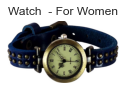

In [42]:
# from PIL import Image
# import os


def preview_image(filename=None, img=None, seed=None, ax=None, titre=None,
                  preprocess_fct=None,
                  preprocess_params={},
                  file_path=IMG_FOLDER):
    if img is None:
        if filename is None:
            if seed is None:
                seed = np.random.randint(0, 1050)
            # seed = 352
            filename = os.listdir(IMG_FOLDER)[seed]

        # Charger l'image
        if file_path is None:
            img = Image.open(filename)
        else:
            img = Image.open(f'{IMG_FOLDER}/{filename}')

    if not preprocess_fct is None:
        img = preprocess_fct(img, preprocess_params)

    # Afficher l'image chargée dans jupyter
    if ax is None:
        fig = plt.figure(figsize=(2, 2))
        ax = plt.gca()
    ax.imshow(img, cmap='gray')
    ax.set_axis_off()

    if titre is None:
        titre = get_product_name_from_filename(filename=filename, short=True)
    ax.set_title(titre)


preview_image(seed=598)


## Affichage d'exemples d'images par label (catégorie niveau 1)



"Test_Preview_Images.png"


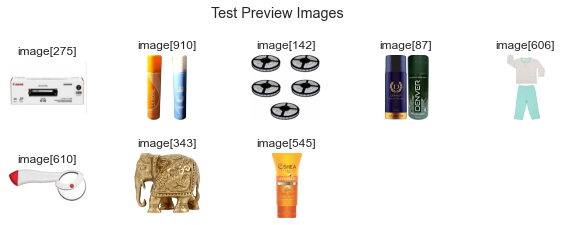

In [43]:
def preview_images(filenames, titles, titre,
                   preprocess_fct=None,
                   preprocess_params={}):
    n_cols = min(5,len(filenames))
    n_rows = len(filenames) // n_cols + (len(filenames) % n_cols > 0)
    fig = plt.figure(figsize=(n_cols*2, n_rows+1))
    for n, filename in enumerate(filenames):
        if len(titles) > n:
            image_title = short_name(' '.join(str(titles[n]).split(' ')))
        else:
            image_title = get_product_name_from_filename(
                filename=filename, short=True)
        ax = plt.subplot(n_rows, n_cols, n + 1)
        preview_image(filename, titre=image_title, ax=ax,
                      preprocess_fct=preprocess_fct, preprocess_params=preprocess_params)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    fig.suptitle(titre, y=1.1)
    to_png()
    plt.show()


# seeds= np.random.randint(0, 1050,8)
seeds = [275, 910, 142, 87, 606, 610, 343, 545]
filenames = [os.listdir(IMG_FOLDER)[seed] for seed in seeds]
titles = [f'image[{seed}]' for seed in seeds]
preview_images(filenames, titles, titre='Test Preview Images')


"Home_Furnishing.png"


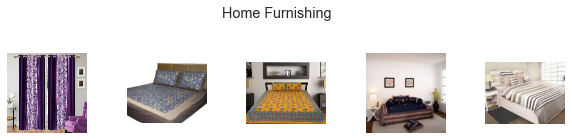

"Baby_Care.png"


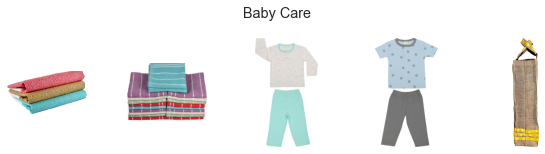

"Watches.png"


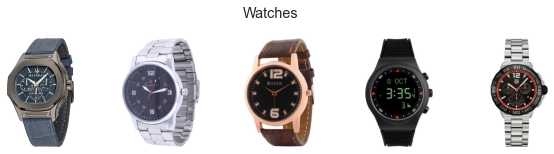

"Home_Decor_&_Festive_Needs.png"


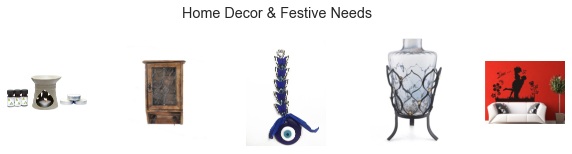

"Kitchen_&_Dining.png"


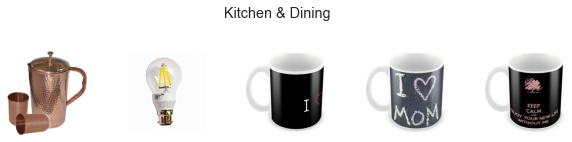

"Beauty_and_Personal_Care.png"


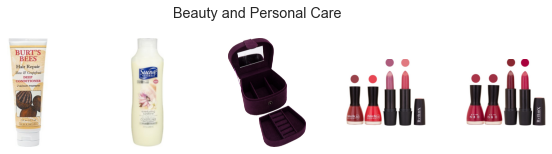

"Computers.png"


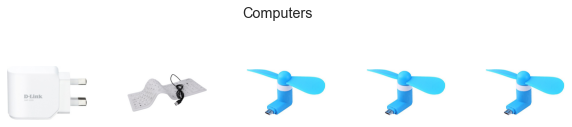

In [106]:
def preview_images_by_category(df, categ_col='categ_level_1',
                               feature='image', nb=5,
                               preprocess_fct=None,
                               preprocess_params={},
                               show_titles=False
                               ):
    """echantillon d'images par catégorie"""
    categories = df[categ_col].unique()
    for n, category in enumerate(categories):
        filenames = df[df[categ_col] == category][feature]
        product_names = df[df[categ_col] == category]['product_name']
        nb_im = min(nb, len(filenames))
        filenames = list(filenames[:nb_im])
        product_names = list(product_names[:nb_im]) if show_titles else ['' for i in range(nb_im)]
        preview_images(filenames, titles=product_names, titre=category,
                       preprocess_fct=preprocess_fct, preprocess_params=preprocess_params)


preview_images_by_category(df_data, nb=5)


In [45]:
df_data.duplicated(subset=['image']).sum()


0

Il y a un image unique pour chaque produit, même si les images peuvent être identiques


## 2.2 Nettoyage des données

Les images peuvent avoir besoin de prétraitement, qui dépend du modèle de machine learning

- conversion de FileFormat
- Egalisation d'exposition (`PIL.ImageOps.autocontrast`)
- Egalisation de contrast (`PIL.ImageOps.equalize` )
- Filtrage de bruit (`PIL.Image.filter.GaussianBlur`)
- Filtrage de bruit (`PIL.Image.filter.MedianFilter`)
- conversion en gris (réduction de dimensions de couleur)
- reduction de taille (square, remplit)

On crée des procédures ci-dessous


### Image témoin

- images pour tester les procédures de prétraitement

> Seeds: [854 ,393, 203, 902, 756 ]


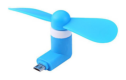

In [46]:

def get_image(seed=None):
    """Fonction pour recupérer un image temoin à tester"""
    if seed is None:
        nb_files = len(os.listdir(IMG_FOLDER))
        seed = np.random.randint(0, nb_files)
        print(f'get_image {seed}')
    filename = os.listdir(IMG_FOLDER)[seed]
    # Charger l'image
    return Image.open(f'{IMG_FOLDER}/{filename}')


# image temoins pour tester
IMG_FAN = get_image(393)  # USB fan
IMG_BULB = get_image(695)  # light bulb
IMG_PIZZA = get_image(854)  # pizza cutter
IMG_LIP = get_image(225)  # lipsticks
IMG_BED = get_image(909)  # dark bed

TEMOINS = [225, 393, 695, 854, 225, 909]
# IMG = get_image()
IMG = IMG_BED
preview_image(img=IMG_FAN)


### Visualisation d'une image et son histogramme

- <https://datacarpentry.org/image-processing/05-creating-histograms/>


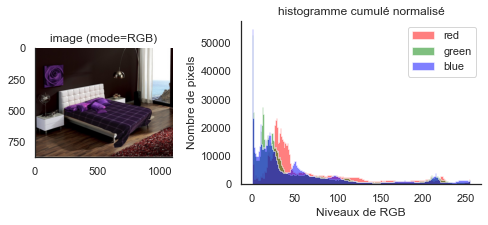

In [47]:
# from PIL import Image
def plot_image_histogram(img, cumul_=False, density_=False, histtype_='stepfilled'):
    if type(img) == np.ndarray:
        img_ = img
        img = Image.fromarray(img)
    else:
        img_ = np.array(img)
        img = img
    fig = plt.figure(figsize=(8, 3))
    gs = fig.add_gridspec(1,9)
    ax = plt.subplot(gs[:, :3])
    ax.imshow(img_, cmap='gray')
    ax.set_title(f'image (mode={img.mode})')

    # Générer et afficher l'histogramme
    # Pour le normaliser : argument density=True dans plt.hist
    # Pour avoir l'histogramme cumulé : argument cumulative=True
    ax = plt.subplot(gs[:, 4:])
    if len(img_.shape) == 3:
        for channel_id, color in enumerate(['red', 'green', 'blue']):
            plt.hist(img_[:, :, channel_id].flatten(), bins=range(256), cumulative=cumul_,
                     color=color, alpha=0.5, label=color, density=density_, histtype=histtype_)
        plt.legend(loc='upper right')
    else:
        # n, bins, patches =
        color = 'gray'
        plt.hist(img_.flatten(), bins=range(256), cumulative=cumul_,
                 color=color, alpha=0.5, label=color, density=density_, histtype=histtype_)
        plt.legend(loc='upper right')

    xlabel = 'RGB' if img.mode == 'RGB' else 'gris'
    ax.set_xlabel(f'Niveaux de {xlabel}')

    if cumul_:
        ax.set_ylabel('Nombre de pixels cumulé')
    else:
        ax.set_ylabel('Nombre de pixels')

    ax.set_title('histogramme cumulé normalisé')
    sns.despine()
    plt.subplots_adjust(wspace=0.5)


# plot_image_histogram(IMG)
# plot_image_histogram(IMG,histtype_='step')
plot_image_histogram(IMG, histtype_='stepfilled')


### Conversion en gris (réduction de dimensions de couleur)


In [48]:
# from PIL import Image


def get_image_mode(img):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    mode = img.mode
    print(f'Image mode : {mode}')
    return mode


get_image_mode(IMG)


Image mode : RGB


'RGB'

"histogram_-_grayscale.png"


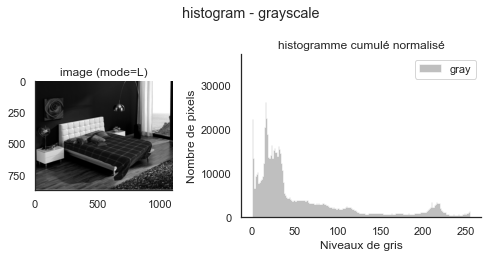

In [49]:
# from PIL import Image
# from PIL.ImageOps import grayscale


def img_to_gray(img):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    return ImageOps.grayscale(img)


plot_image_histogram(img_to_gray(IMG))
plt.suptitle('histogram - grayscale', y=1.1)
to_png()

"histogram_-_opaque.png"


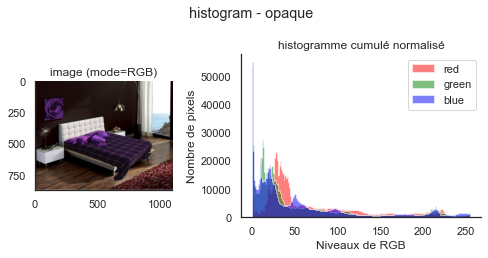

In [50]:
# from PIL import Image


def img_opaque(img, bg_colour=(255, 255, 255)):
    """Remove image transparency (https://stackoverflow.com/a/35859140/)"""
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
        print('image has transparency')
        # Need to convert to RGBA if LA format due to a bug in PIL (http://stackoverflow.com/a/1963146)
        alpha = img.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format
        # (http://stackoverflow.com/a/8720632  and  http://stackoverflow.com/a/9459208)
        bg = Image.new("RGBA", img.size, bg_colour + (255,))
        bg.paste(img, mask=alpha)
        return bg
    return img


plot_image_histogram(img_opaque(IMG))
plt.suptitle('histogram - opaque', y=1.1)
to_png()

### Egalisation d'exposition

Utilisant (`PIL.ImageOps.autocontrast`)


"histogram_-_autocontrast.png"


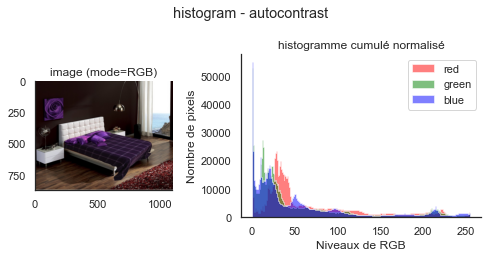

In [51]:
# from PIL.ImageOps import autocontrast
# from PIL import Image


def img_contrast(img, cutoff=1):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    img_etire = ImageOps.autocontrast(img, cutoff=cutoff)
    return img_etire


plot_image_histogram(img_contrast(IMG))
plt.suptitle('histogram - autocontrast', y=1.1)
to_png()

### Egalisation de contrast avec PIL

(`PIL.ImageOps.equalize` )


"histogram_-_equalize_(PIL).png"


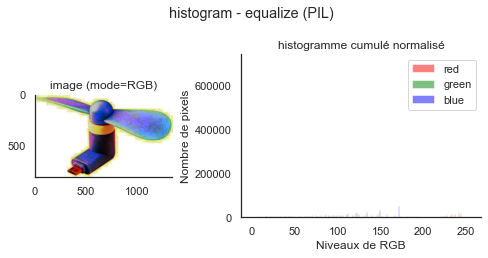

In [52]:
# from PIL.ImageOps import equalize
# from PIL import Image

def img_equalize_pil(img):
    """equalize histogram using PIL"""
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    return ImageOps.equalize(img)


# IMG_FAN et IMG_BULB ne marche pas bien
plot_image_histogram(img_equalize_pil(IMG_FAN))
plt.suptitle('histogram - equalize (PIL)', y=1.1)
to_png()

### Egalisation de contrast avec openCV

(`cv2.equalizeHist` )

- <https://pythonmana.com/2021/10/20211007114859814f.html>


"histogram_-_equalize_(openCV).png"


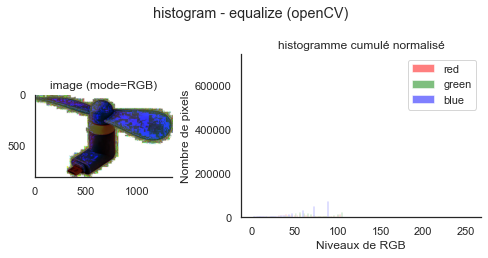

In [53]:

# import cv2


def img_equalize_hist(img):
    """equalize histogram using openCV"""
    # else : # use cv2
    if type(img) != np.ndarray:
        img = np.array(img)

    if len(img.shape) == 3:
        channels = cv2.split(img)
        eq_channels = []
        for ch in channels:
            eq_channels.append(cv2.equalizeHist(ch))
        eq_image = cv2.merge(eq_channels)
        return eq_image
    else:
        return cv2.equalizeHist(img)


plot_image_histogram(img_equalize_hist(IMG_FAN))
plt.suptitle('histogram - equalize (openCV)', y=1.1)
to_png()

### Egalisation de contrast avec CLAHE

Contrast Limited Adaptive Histogram Equalization
(`cv2.ImageOps.equalize` )

- <https://pythonmana.com/2021/10/20211007114859814f.html#3__169>


"histogram_-_equalize_(CLAHE).png"


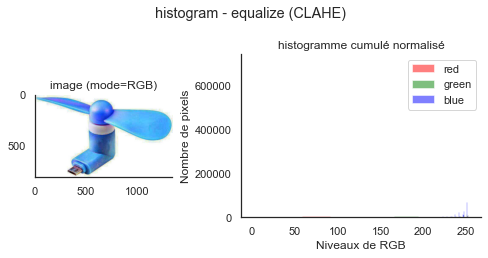

In [54]:
# import cv2


def img_equalize_clahe(img, clip_limit=4.0):
    """equalize histogram using CLAHE"""
    if type(img) != np.ndarray:
        img = np.array(img)

    clahe = cv2.createCLAHE(clipLimit=clip_limit)

    if len(img.shape) == 3:
        channels = cv2.split(img)
        eq_channels = []
        for ch in channels:
            eq_channels.append(clahe.apply(ch))
        eq_image = cv2.merge(eq_channels)
        return eq_image
    else:
        return clahe.apply(img)


plot_image_histogram(img_equalize_clahe(IMG_FAN))
plt.suptitle('histogram - equalize (CLAHE)', y=1.1)
to_png()

### Filtrage de bruit

- (`PIL.Image.filter.GaussianBlur`)


"histogram_-_gaussian_blur_(radius=20).png"


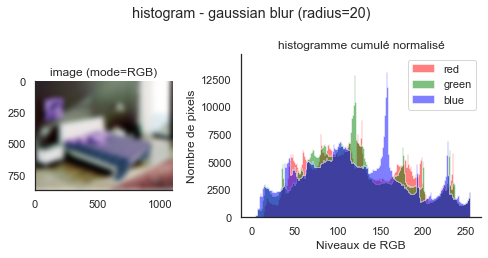

In [55]:
# from PIL.ImageFilter import GaussianBlur


def img_gaussian_blur(img, radius=3):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    return img.filter(ImageFilter.GaussianBlur(radius))


plot_image_histogram(img_gaussian_blur(
    img_equalize_hist(img_contrast(IMG)), radius=20))
plt.suptitle('histogram - gaussian blur (radius=20)', y=1.1)
to_png()


### Filtrage de bruit (`PIL.Image.filter.MedianFilter`)

Ce filtre est non-lineaire qui donne les meilleur résultats mais prend plus de temps.


Text(0.5, 1.1, 'histogram - equalized median blur (size=3)')

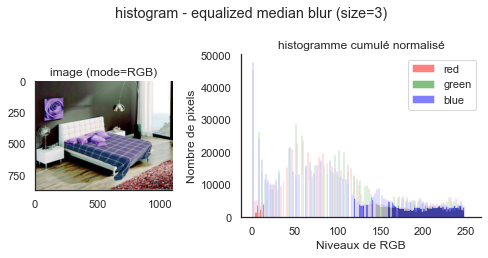

In [56]:
# from PIL import Image
# from PIL.ImageFilter import MedianFilter


def img_median_blur(img, size=3):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    return img.filter(ImageFilter.MedianFilter(size=size))


plot_image_histogram(img_median_blur(img_equalize_hist(IMG)))
plt.suptitle('histogram - equalized median blur (size=3)', y=1.1)


### Changer en forme carré (remplit)


In [57]:
# from PIL import Image


def get_image_size(img):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    w, h = img.size
    return w, h


w, h = get_image_size(IMG)
print(f'Largeur : {w} px, hauteur : {h} px')


Largeur : 1100 px, hauteur : 872 px


(1100, 1100)
"histogram_-_squarify_(size=3).png"


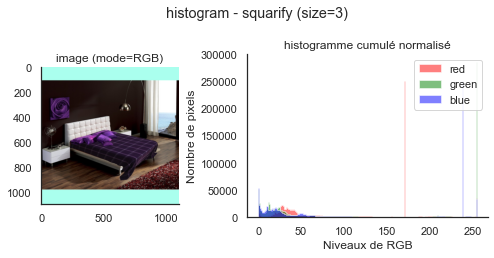

In [58]:
# from PIL import Image


def img_squarify(img, bgcolor='white'):
    """
    Change en carré pour entré dans un algorithme que attend des images carrés
    La plupart des algorithmes sont invariant au stretch, donc pas 
    """
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    w, h = img.size
    if w != h:
        max_hw = max(h, w)
        img_square = Image.new(img.mode, (max_hw, max_hw), bgcolor)
        img_square.paste(img, ((max_hw-w)//2, (max_hw-h)//2))
        img = img_square
    return img


sqr_img = img_squarify(IMG, bgcolor='#AAFFEE')
print(get_image_size(sqr_img))
plot_image_histogram(sqr_img)
plt.suptitle('histogram - squarify (size=3)', y=1.1)
to_png()


### Reduction de taille


(224, 224)


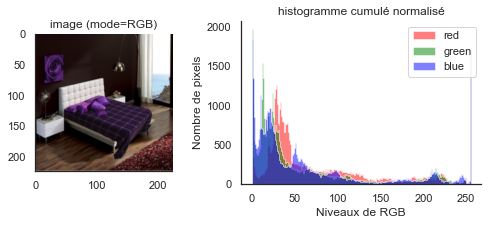

In [59]:
# from PIL import Image

def img_resize_pil(img, sq_size=224, resample=Image.BILINEAR):
    # resample = Image.LINEAR, BILINEAR, BICUBIC, ou LANCZOS
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    w, h = img.size
    max_hw = max(h, w)
    scale = sq_size/max_hw
    new_w = sq_size if w >= h else int(w*scale)
    new_h = sq_size if h >= h else int(h*scale)
    return img.resize((new_w, new_h), resample=resample)


res_img = img_resize_pil(IMG)
print(get_image_size(res_img))
plot_image_histogram(res_img)


(1100, 872)
(224, 224)


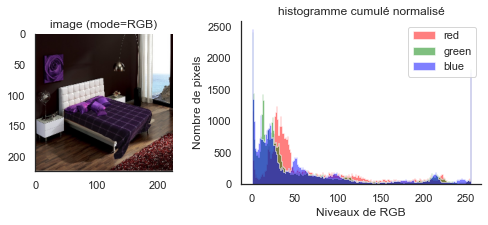

In [60]:
def img_resize(img, sq_size=224, interpolation=Image.ANTIALIAS):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    w, h = img.size
    max_hw = max(h, w)
    scale = sq_size/max_hw
    new_w = sq_size if w >= h else int(w*scale)
    new_h = sq_size if h >= h else int(h*scale)
    return cv2.resize(np.asarray(img), (new_w, new_h), interpolation)


res_img = img_resize(IMG)
print(get_image_size(IMG))
print(get_image_size(res_img))
plot_image_histogram(res_img)


## Pipeline de pretraitement d'un image


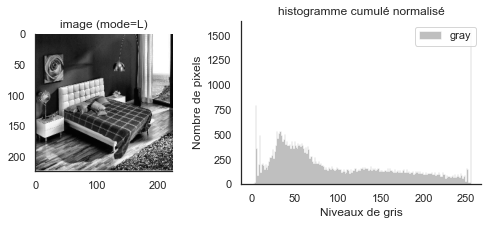

In [61]:
preprocess_params={
    'resize':{'sq_size':224},
     'gray':True,
     'squarify':False,
     'equalize':True,
     'contrast':False,
    #  'filter_gauss':{'radius':1},
    #  'filter_median':{'size':1},
}


def img_preprocess(img, params=preprocess_params):
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    if params.get('gray'):
        img=img_to_gray(img)
    if params.get('squarify'):
        img = img_squarify(img)
    if params.get('resize'):
        img = img_resize(img, sq_size=params.get('resize').get('sq_size',24))
    if params.get('contrast'):
        img=img_contrast(img)   
    if params.get('equalize'):
        img = img_equalize_clahe(img)        
    if params.get('filter_gauss'):
        img = img_gaussian_blur(img,radius=params.get('filter_gauss').get('radius',1)) 
    if params.get('filter_median'):
        img = img_median_blur(img, size=params.get('filter_median').get('size',1))  



    return img

img_processed = img_preprocess(IMG)
plot_image_histogram(img_processed)
  

In [62]:
# Ajuste manuelle des prétraitements


"Home_Furnishing.png"


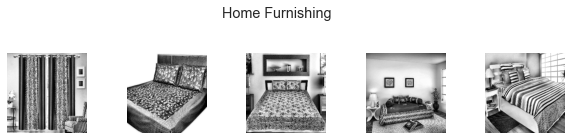

"Baby_Care.png"


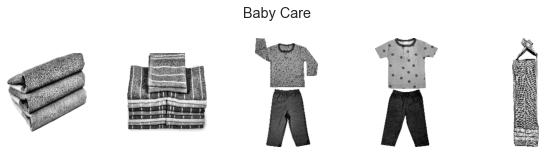

"Watches.png"


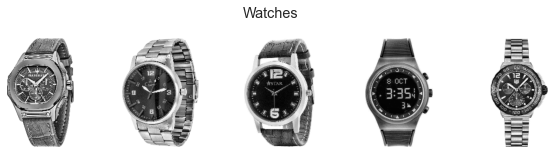

"Home_Decor_&_Festive_Needs.png"


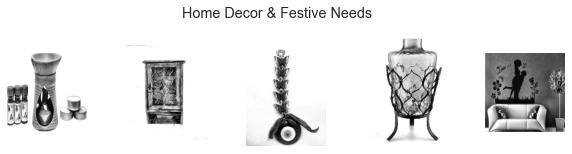

"Kitchen_&_Dining.png"


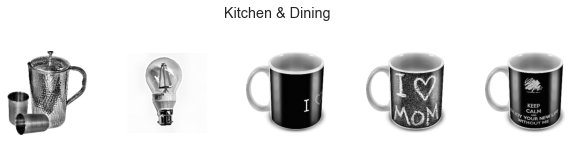

"Beauty_and_Personal_Care.png"


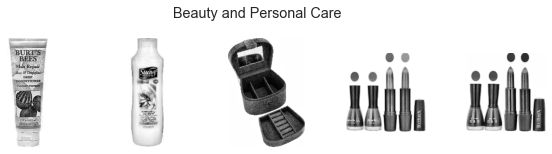

"Computers.png"


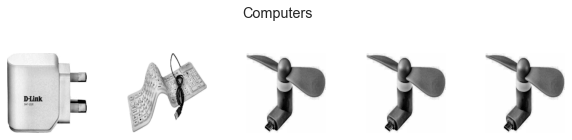

In [63]:
preprocess_params = {
    'resize': {'sq_size': 224},
    'gray': True,   
    'contrast':True,
    'equalize': True,
    # 'squarify': False,

    #  'filter_gauss':{'radius':1},
    #  'filter_median':{'size':1},
}

preview_images_by_category(
    df_data, preprocess_fct=img_preprocess, preprocess_params=preprocess_params, show_titles=False)


## Enregistre les images prétraités

- Si le nombre d'images est grand ou la prétraitement prend du temps, on peut enregistrer les images prêt pour le feature extraction
- Pour la tâche actuel, le nombre d'images est petit et le preprocessing rapide


#### Nettoyage des variables globales


In [64]:

# %who DataFrame
del df_test_cols
del df_test_rows


---


# 3. Extraction de features

- Methode SIFT (Scale-Invariant Feature Transform)
- Methode ORB ()


## 3.1 SIFT - (Scale-Invariant Feature Transform)

Methode SIFT (Scale-Invariant Feature Transform)

- <https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html>


### Création des labels des photos à partir du catégorie niveau 1


In [65]:
# from sklearn import preprocessing

df_data['label_name'] = df_data['categ_level_1']


le = preprocessing.LabelEncoder()
df_data['label'] = le.fit_transform(df_data['categ_level_1'])
print(sorted(list(df_data['label'].unique())))
(df_data[['label', 'categ_level_1']].value_counts()
 .to_frame('count').reset_index()
 .sort_values(by='label'))


[0, 1, 2, 3, 4, 5, 6]


label               categ_level_1  count
6      0                   Baby Care    150
5      1    Beauty and Personal Care    150
4      2                   Computers    150
3      3  Home Decor & Festive Needs    150
2      4             Home Furnishing    150
1      5            Kitchen & Dining    150
0      6                     Watches    150

## Affichage d'exemples d'images par label


## Détermination et affichage des descripteurs SIFT

- L'image contient 319 descripteurs
- Chaque descripteur est un vecteur de longueur 128


644
"SIFT_no_keypoints.png"


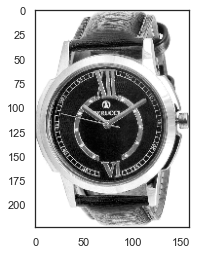

"SIFT_with_keypoints.png"


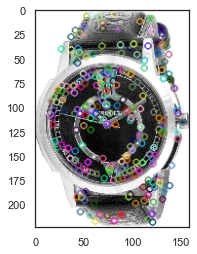

Descripteurs :  (295, 128)
[[ 47.  27.   0. ...   0.   0.  48.]
 [154.  52.   0. ...   2.   0.   3.]
 [ 15.  16.  22. ...   2.   1.  28.]
 ...
 [  0.   0.   0. ...  14.   0.   0.]
 [  1.  32. 127. ...  38.  10.   0.]
 [  0.   0.   0. ...  77.  76.   6.]]


In [66]:
import cv2
seed = np.random.randint(0, 1050)
# seed= 396
seed = 644
print(seed)
sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(f'{path}/{LIST_PHOTOS[seed]}', 0)  # convert in gray

image = np.array(img_preprocess(image, preprocess_params))

plt.imshow(image, cmap='gray')
to_png('SIFT_no_keypoints')
plt.show()
# image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) # already grey
# image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
to_png('SIFT_with_keypoints')
plt.show()
print("Descripteurs : ", des.shape)
print(des)


# Pré-traitement des images via SIFT


## Créations des descripteurs de chaque image

- Pour chaque image passage en gris et equalisation
- création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
- création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs


In [67]:
# identification of key points and associated descriptors
# 15 minutes sans preprocessing (517351 descriptors)
# 40 seconds avec preprocessing (265713 descriptors)
import time
import cv2

# SIFT est très lent si on ne réduit pas la taille des images (resize)
preprocess_params = {
    'resize': {'sq_size': 224},
    #  'gray':True,
    #  'squarify':False,
    'equalize': True,
    'contrast': True,
    #  'filter_gauss':{'radius':1},
    'filter_median': {'size': 1},
}

sift_keypoints = []
temps1 = time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

image_files = list(df_data['image'])
for image_num, image_filename in enumerate(image_files):
    if image_num % 100 == 0:
        print(image_num)
    image = cv2.imread(f'{path}/{image_filename}', 0)  # convert in gray
    res = np.array(img_preprocess(image, preprocess_params))
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    if des is None:
        print('no descriptors found for image_num {image_num}')
        des = [np.zeros((128,))]
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1 = time.time()-temps1
print("temps de traitement SIFT descriptor : ",
      "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (297837, 128)
temps de traitement SIFT descriptor :            34.27 secondes


## Création des clusters de descripteurs

- Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables


In [68]:
# from sklearn import cluster

# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(
    n_clusters=k, init_size=3*k, batch_size=2048, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1 = time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")


Nombre de clusters estimés :  546
Création de 546 clusters de descripteurs ...
temps de traitement kmeans :             5.66 secondes


## Création des features des images

- Pour chaque image :
  - prédiction des numéros de cluster de chaque descripteur
  - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image


Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster


In [69]:
# Creation of histograms (features)
temps1 = time.time()


def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    if i % 100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             3.33 secondes


## Réductions de dimension


### Réduction de dimension PCA

- La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
- L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE


In [70]:
feat_pca = reducer_pca(im_features)


Dimensions avant réduction PCA  (99 % variance explained)  : (1050, 546)
Dimensions après réduction PCA :  (1050, 446)


### Réduction de dimension T-SNE

- Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images


In [71]:
# from sklearn import manifold

tsne = manifold.TSNE(n_components=2, perplexity=30, learning_rate=200,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])

df_tsne["class"] = df_data["label_name"]
print(df_tsne.shape)


(1050, 3)


## KMeans : détermination de nombre de clusters des images


In [72]:
search_params = {'n_clusters': range(4, 15)}
scores_sift, labels_sift = score_kmeans(
    X_tsne, param_grid=search_params, labels_true=df_data['categ_level_1'])
scores_sift.head()


k=4, fit: 0.13 s, silhouette= 0.363, ARI = 0.028, cluster sizes = [34 22 22 21]
k=5, fit: 0.16 s, silhouette= 0.355, ARI = 0.024, cluster sizes = [27 19 18 18 16]
k=6, fit: 0.21 s, silhouette= 0.354, ARI = 0.027, cluster sizes = [25 17 16 14 14 12]
k=7, fit: 0.17 s, silhouette= 0.355, ARI = 0.025, cluster sizes = [23 16 13 13 12 11  9]
k=8, fit: 0.17 s, silhouette= 0.363, ARI = 0.034, cluster sizes = [19 15 11 11 10 10 10  9]
k=9, fit: 0.19 s, silhouette= 0.369, ARI = 0.043, cluster sizes = [18 14 10 10 10 10  9  9  6]
k=10, fit: 0.4 s, silhouette= 0.366, ARI = 0.046, cluster sizes = [15 14 10 10  9  9  8  8  7  6]
k=11, fit: 0.27 s, silhouette= 0.364, ARI = 0.049, cluster sizes = [15 12 10  9  8  8  8  7  7  6  5]
k=12, fit: 0.21 s, silhouette= 0.353, ARI = 0.051, cluster sizes = [14 10  9  9  8  8  8  8  6  6  6  5]
k=13, fit: 0.25 s, silhouette= 0.35, ARI = 0.04, cluster sizes = [10 10  9  8  8  8  7  7  6  6  6  5  5]
k=14, fit: 0.24 s, silhouette= 0.35, ARI = 0.038, cluster sizes 

ARI  calinski_harabasz  davies_bouldin  distortion_score  fit_time_cluster  \
0 0.03             790.18            0.91          54879.00              0.13   
1 0.02             800.49            0.87          44106.00              0.16   
2 0.03             802.86            0.86          36996.00              0.21   
3 0.03             803.49            0.83          31883.00              0.17   
4 0.03             827.43            0.81          27331.00              0.17   

   k  min_cluster_pct  silhouette_score classifier  
0  4            21.05              0.36     KMeans  
1  5            16.48              0.35     KMeans  
2  6            12.67              0.35     KMeans  
3  7             9.71              0.35     KMeans  
4  8             9.52              0.36     KMeans

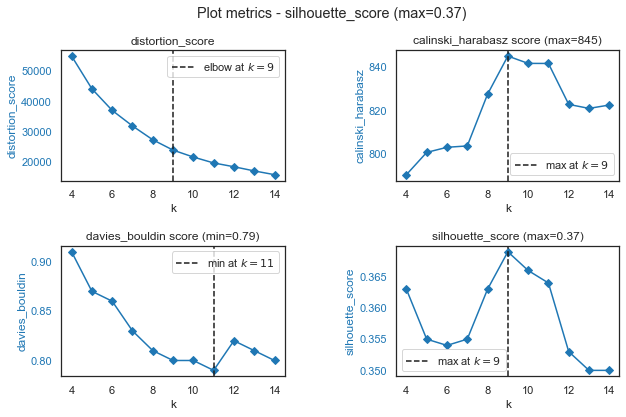

In [73]:
plot_metrics(scores_sift)


## Analyse visuelle : affichage T-SNE selon catégories d'images

- On regarde si le t-SNE montre les catégories pas partiellement séparées


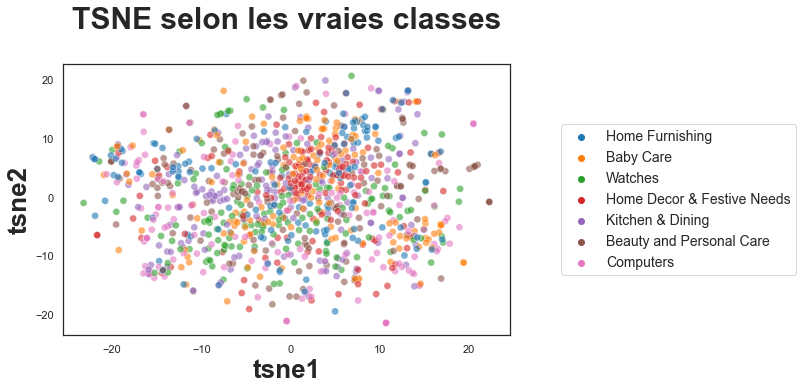

In [74]:
def plot_tsne_by_group(df_tsne_, hue='class'):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_tsne_, x="tsne1", y="tsne2", hue="class", legend="brief",
                    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

    plt.title('TSNE selon les vraies classes',
              fontsize=30, pad=35, fontweight='bold')
    plt.xlabel('tsne1', fontsize=26, fontweight='bold')
    plt.ylabel('tsne2', fontsize=26, fontweight='bold')
    plt.legend(prop={'size': 14}, loc=6, bbox_to_anchor=(1.1, 0.5))


plot_tsne_by_group(df_tsne, hue='class')


## Analyse mesures : similarité entre catégories et clusters


### Création de clusters à partir du T-SNE


In [75]:
# from sklearn import cluster
categories = df_data['label_name'].unique()
nb_clusters = 10
cls = cluster.KMeans(n_clusters=nb_clusters, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


### Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

- Le score ARI (0.04) reste faible


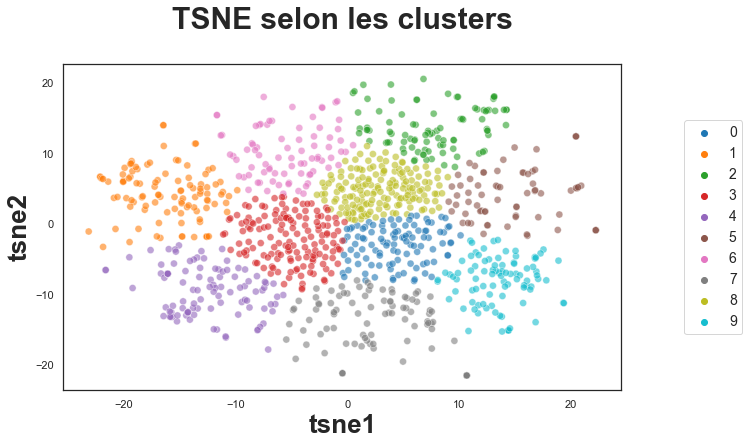

ARI :  0.046341859942354326


In [76]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=nb_clusters), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14}, loc=6, bbox_to_anchor=(1.1, 0.5))

plt.show()

labels = df_data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))


### Analyse par classes

- La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
- Cette transformation atteint ses limites pour les 2 catégories "shine" et "sunshine" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax")


In [77]:
df_tsne.groupby("cluster").count()["class"]


cluster
0    105
1    106
2     93
3    150
4    100
5     69
6     81
7     92
8    163
9     91
Name: class, dtype: int64

In [78]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)


[[13 10 22 23  8  2 10  6 29 27]
 [16 18 10 24  8 27 18 16  9  4]
 [12 22  7 11 27  8  8 26  5 24]
 [14  5 11  9  8  7  6 12 69  9]
 [19 29 32 14  8  4  8  7 22  7]
 [14 13 10 29 19  8 18 13 18  8]
 [17  9  1 40 22 13 13 12 11 12]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]


In [79]:
conf_matrix, labelmap = conf_matrix_labels(
    df_data['categ_level_1'], cls.labels_)
conf_matrix.style.background_gradient(axis=1)


"1.png"


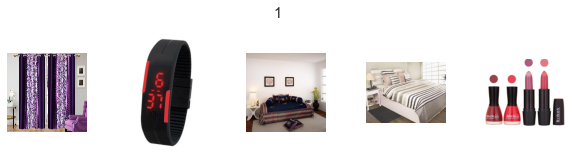

"4.png"


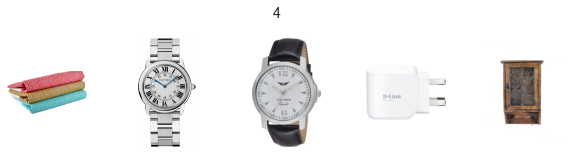

"7.png"


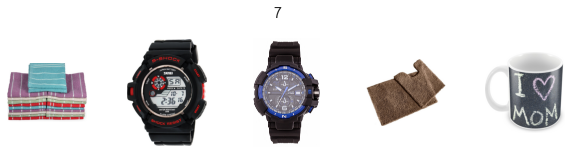

"2.png"


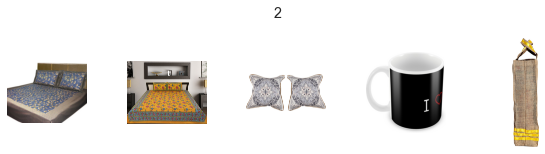

"9.png"


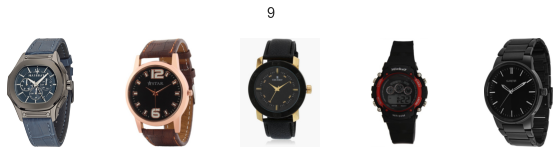

"6.png"


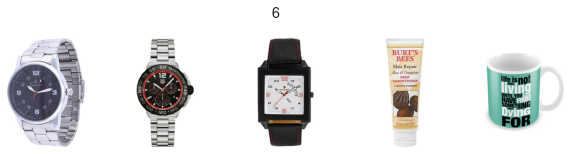

"0.png"


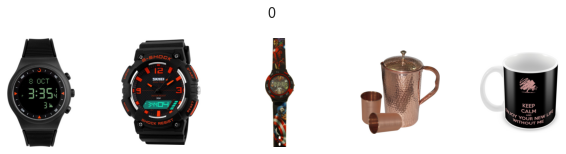

"3.png"


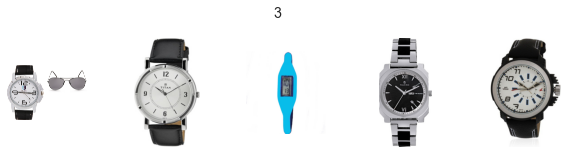

"5.png"


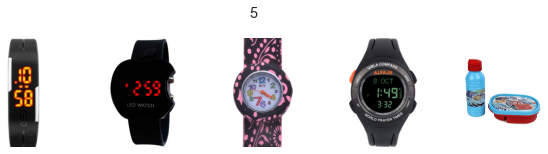

"8.png"


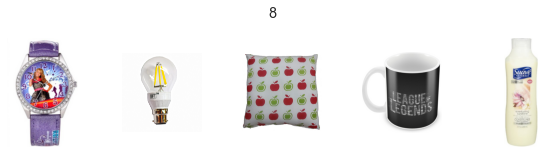

In [80]:
df_data['label_sift'] = cls.labels_
preview_images_by_category(df_data, categ_col='label_sift', nb=5)


In [81]:
# from sklearn import metrics

def conf_mat_transform(y_true, y_pred):
    """attribuer chaque cluster de y_pred à un des groupes de y_true"""
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    # corresp = [3, 1, 2, 0]
    print("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']


cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)

print(metrics.classification_report(labels, cls_labels_transform, zero_division=0))


Correspondance des clusters :  [4 4 4 6 2 1 1 2 3 0]
[[27 12 14 29 45  0 23]
 [ 4 45 24  9 44  0 24]
 [24 16 53  5 41  0 11]
 [ 9 13 20 69 30  0  9]
 [ 7 12 15 22 80  0 14]
 [ 8 26 32 18 37  0 29]
 [12 26 34 11 27  0 40]]
              precision    recall  f1-score   support

           0       0.30      0.18      0.22       150
           1       0.30      0.30      0.30       150
           2       0.28      0.35      0.31       150
           3       0.42      0.46      0.44       150
           4       0.26      0.53      0.35       150
           5       0.00      0.00      0.00       150
           6       0.27      0.27      0.27       150

    accuracy                           0.30      1050
   macro avg       0.26      0.30      0.27      1050
weighted avg       0.26      0.30      0.27      1050



<AxesSubplot:>

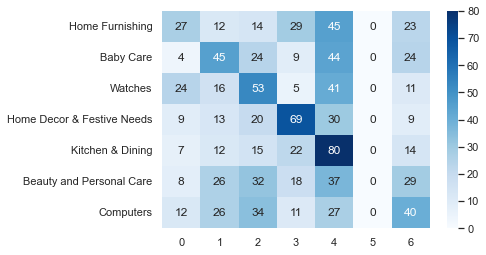

In [83]:
df_cm = pd.DataFrame(conf_mat, index=[label for label in categories],
                     columns=[i for i in range(7)])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")


Visualise images sur t-SNE

- https://nextjournal.com/ml4a/image-t-sne
- https://www.kaggle.com/code/gaborvecsei/plants-t-sne/notebook


"visualisation_des_produits_sur_TSNE_pour_les_top_PCA_des_features_SIFT.png"


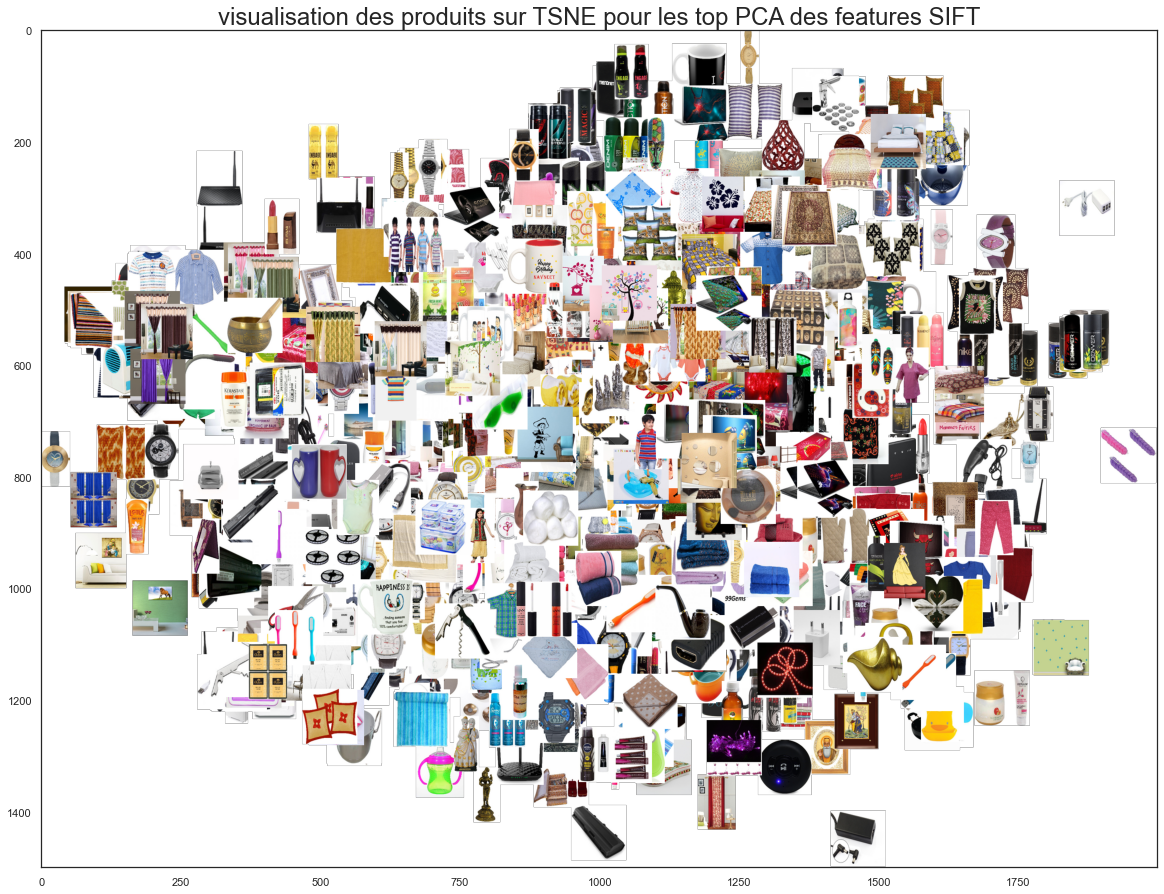

In [84]:
# from PIL import Image
# import random


def plot_scatter_with_images(X_2d_data, filelist, figsize=(20, 20), sample_size=1000, filepath=IMG_FOLDER):
    """visualise images sur t-SNE
    Parameters
    ----------
    X_2d_data np.array or pd.DataFrame of shape [m, n>=2]
    filelist   list of filenames in filepath, or full path to file if filepath is None
    """
    if len(filelist) > sample_size:
        sort_order = sorted(random.sample(range(len(filelist)), sample_size))
        filelist = [filelist[i] for i in sort_order]
        X_2d_data = X_2d_data[sort_order]

    tx, ty = X_2d_data[:, 0], X_2d_data[:, 1]
    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    # 0 is top, so invert ty position for same form as a scatterplot
    ty = (np.max(ty)-ty) / (np.max(ty) - np.min(ty))

    width = 2000
    height = 1500
    max_dim = 100

    # Disable DecompressionBombWarning:
    # Image size (93680328 pixels) exceeds limit of 89478485 pixels
    max_pixels = Image.MAX_IMAGE_PIXELS
    Image.MAX_IMAGE_PIXELS = 93680328+1
    full_image = Image.new('RGBA', (width, height))
    for filename, x, y in zip(filelist, tx, ty):
        if filepath is None:
            tile = Image.open(filename)
        else:
            tile = Image.open(f'{filepath}/{filename}')
        tile = Image.fromarray(img_resize(tile))
        # tile = Image.fromarray(img)
        rs = max(1, tile.width/max_dim, tile.height/max_dim)
        tile = tile.resize(
            (int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
        full_image.paste(tile, (int((width-max_dim)*x),
                         int((height-max_dim)*y)), mask=tile.convert('RGBA'))

    Image.MAX_IMAGE_PIXELS = max_pixels
    plt.figure(figsize=figsize)
    plt.imshow(full_image)


plot_scatter_with_images(X_tsne[:, 0:2], df_data['image'])
plt.title('visualisation des produits sur TSNE pour les top PCA des features SIFT', fontsize=24)
to_png()


In [85]:
# list variables
# %who


In [86]:
# delete variables used by sift

del df_tsne
del sift_keypoints_all
del sift_keypoints_by_img
del sift_keypoints
del sift


# 4. ORB (Oriented FAST and Rotated BRIEF)

ORB était crée en 2011, est et opensource (SIFT n'a plus de brevet depuis 2021)

- https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html


644
"ORB_no_keypoints.png"


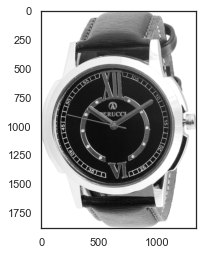

"ORB_with_keypoints.png"


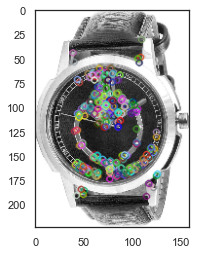

Descripteurs :  (362, 32)
[[106 223 104  28  93 221 212 255 203  79 188 175  42  60  22 116 205 147
  223   5 238  43 118 255 127 127 148 187  87  92 222  95]
 [129 225 121 225 126 141 169  92  74 181  17 218 149 133  80  34  46  29
   83  89 131  60 254  18  77 136  41 108  69 139   7 232]
 [184  50  54  25   3 254 113  81 117 109 247  53  11  22 130 253  96 140
  238  16 191 254 117 133 215 243  48 195 106 132 108  87]]


In [87]:
import cv2
seed = np.random.randint(0, 1050)
# seed= 396 # mug
seed = 644  # watch
# seed = 491
print(seed)
orb = cv2.ORB_create(nfeatures=500)
image = cv2.imread(f'{path}/{LIST_PHOTOS[seed]}', 0)  # convert in gray
# image= np.array(img_preprocess(image,preprocess_params))
# image = np.array(img_resize(image,sq_size=288))
plt.imshow(image, cmap='gray')
to_png('ORB_no_keypoints')
plt.show()
# image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) # already grey
image = img_resize(image, sq_size=224)
image = img_equalize_clahe(image)   # equalize image histogram
kp, des = orb.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
to_png('ORB_with_keypoints')
plt.show()
print("Descripteurs : ", des.shape)
print(des[:3])


In [88]:
image_idx(df_data['image'][30])


491

## Pré-traitement des images via ORB


### Créations des descripteurs de chaque image

- Pour chaque image passage en gris et equalisation
- création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
- création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs


In [89]:
# identification of key points and associated descriptors
# 15 minutes sans preprocessing (517351 descriptors)
# 40 seconds avec preprocessing (265713 descriptors)
import time
import cv2

preprocess_params = {
    'resize': {'sq_size': 224},
    #  'gray':True,
    #  'squarify':False,
    'equalize': True,
    'contrast': True,
    #  'filter_gauss':{'radius':1},
    #  'filter_median':{'size':1},
}

orb_keypoints = []
temps1 = time.time()
orb = cv2.ORB_create()

image_files = list(df_data['image'])
for image_num, image_filename in enumerate(image_files):
    if image_num % 100 == 0:
        print(image_num)
    image = cv2.imread(f'{path}/{image_filename}', 0)  # convert in gray
    # res= np.array(img_preprocess(image,preprocess_params))
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # res = cv2.equalizeHist(image)   # equalize image histogram
    res = img_equalize_clahe(image)
    kp, des = orb.detectAndCompute(res, None)
    if des is None:
        print(f'no descriptors found for image_num {image_num}')
        des = [np.zeros((128,))]
    orb_keypoints.append(des)

orb_keypoints_by_img = np.asarray(orb_keypoints, dtype=object)
orb_keypoints_all = np.concatenate(orb_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", orb_keypoints_all.shape)

duration1 = time.time()-temps1
print("temps de traitement ORB descriptor : ",
      "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (517420, 32)
temps de traitement ORB descriptor :            97.19 secondes


## Création des clusters de descripteurs

- Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables


In [90]:
# from sklearn import cluster

# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(
    n_clusters=k, init_size=3*k, batch_size=2048, random_state=0)
kmeans.fit(orb_keypoints_all)

duration1 = time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")


Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :            10.69 secondes


## Création des features des images

- Pour chaque image :
  - prédiction des numéros de cluster de chaque descripteur
  - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image


Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster


In [91]:
# Creation of histograms (features)
temps1 = time.time()


def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(orb_keypoints_by_img):
    if i % 100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             9.04 secondes


## Réductions de dimension


### Réduction de dimension PCA

- La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
- L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE


In [92]:
# from sklearn import decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)


Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 591)


### Réduction de dimension T-SNE

- Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images


In [93]:
# from sklearn import manifold

tsne = manifold.TSNE(n_components=2, perplexity=30, learning_rate=200,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])

df_tsne["class"] = df_data["label_name"]
print(df_tsne.shape)


(1050, 3)


## KMeans : détermination de nombre de clusters des images


In [94]:
search_params = {'n_clusters': range(4, 15)}
scores_orb, labels_orb = score_kmeans(
    X_tsne, param_grid=search_params, labels_true=df_data['categ_level_1'])
scores_orb.head()


k=4, fit: 0.13 s, silhouette= 0.386, ARI = 0.034, cluster sizes = [28 26 25 18]
k=5, fit: 0.19 s, silhouette= 0.388, ARI = 0.041, cluster sizes = [23 22 20 18 14]
k=6, fit: 0.19 s, silhouette= 0.371, ARI = 0.042, cluster sizes = [19 18 17 16 16 11]
k=7, fit: 0.26 s, silhouette= 0.361, ARI = 0.047, cluster sizes = [18 16 14 14 13 13  9]
k=8, fit: 0.22 s, silhouette= 0.354, ARI = 0.044, cluster sizes = [14 14 14 13 13 12  9  7]
k=9, fit: 0.28 s, silhouette= 0.359, ARI = 0.044, cluster sizes = [14 13 12 12 12 10  8  8  7]
k=10, fit: 0.24 s, silhouette= 0.363, ARI = 0.04, cluster sizes = [12 12 12 11 10  9  8  8  7  6]
k=11, fit: 0.31 s, silhouette= 0.359, ARI = 0.039, cluster sizes = [12 11 11 10  9  8  8  8  7  6  6]
k=12, fit: 0.28 s, silhouette= 0.35, ARI = 0.036, cluster sizes = [10  9  9  8  8  8  8  8  7  7  6  6]
k=13, fit: 0.27 s, silhouette= 0.343, ARI = 0.033, cluster sizes = [10  9  9  8  8  8  7  7  7  6  5  5  5]
k=14, fit: 0.3 s, silhouette= 0.339, ARI = 0.035, cluster sizes

ARI  calinski_harabasz  davies_bouldin  distortion_score  fit_time_cluster  \
0 0.03            1112.21            0.88          76125.00              0.13   
1 0.04            1172.17            0.82          58133.00              0.19   
2 0.04            1148.34            0.84          49072.00              0.19   
3 0.05            1116.66            0.85          42964.00              0.26   
4 0.04            1098.00            0.87          38080.00              0.22   

   k  min_cluster_pct  silhouette_score classifier  
0  4            18.76              0.39     KMeans  
1  5            14.00              0.39     KMeans  
2  6            11.71              0.37     KMeans  
3  7             9.90              0.36     KMeans  
4  8             7.90              0.35     KMeans

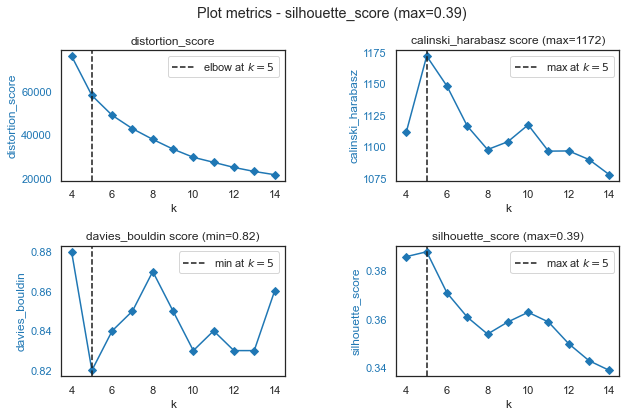

In [95]:
plot_metrics(scores_orb)


## Analyse visuelle : affichage T-SNE selon catégories d'images

- On ne voit pas grande séparation


"tsne_orb_vraie_classes-png.png"


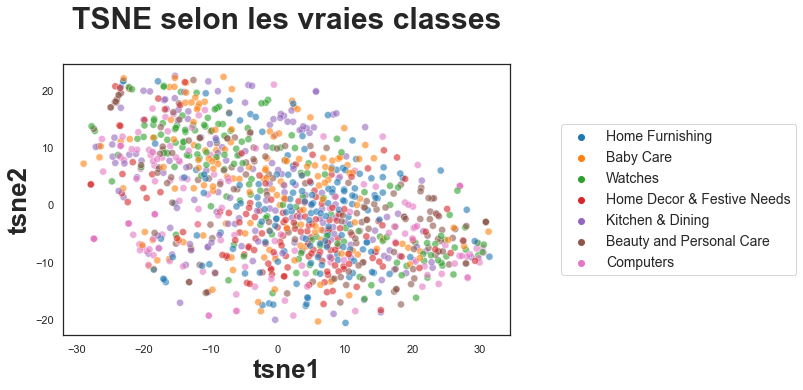

In [96]:
plot_tsne_by_group(df_tsne, hue='class')
to_png('tsne_orb_vraie_classes.png')


## Analyse mesures : similarité entre catégories et clusters


### Création de clusters à partir du T-SNE


In [97]:
# from sklearn import cluster
categories = df_data['label_name'].unique()
nb_clusters = 10
cls = cluster.KMeans(n_clusters=nb_clusters, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


### Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

- Le score ARI de 0.04 est très faible


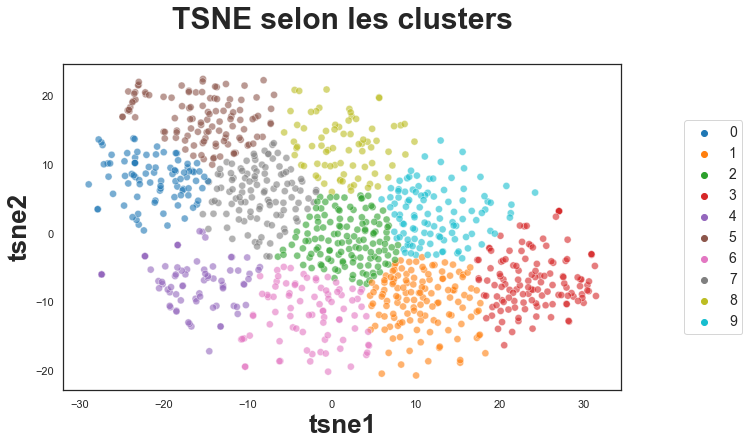

ARI :  0.040964989291111184


In [98]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=nb_clusters), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")


plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14}, loc=6, bbox_to_anchor=(1.1, 0.5))
plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.show()

labels = df_data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))


### Analyse par classes

- La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
- Cette transformation atteint ses limites pour les 2 catégories "shine" et "sunshine" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax")


In [99]:
df_tsne.groupby("cluster").count()["class"]


cluster
0     86
1    133
2    133
3    127
4     78
5    111
6     86
7    112
8     76
9    108
Name: class, dtype: int64

In [100]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)


[[ 8 11 20  9 12 20 11 27 15 17]
 [11 21  8 36  9 17  6 16  8 18]
 [28  5  1 33 29  7 18 15  3 11]
 [12 37 36 11  2  9 24  4  2 13]
 [ 1 27 30  4 11  7 14 10 11 35]
 [15 17 23  8 14 17  6 16 26  8]
 [11 15 15 26  1 34  7 24 11  6]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]


<AxesSubplot:xlabel='col_0', ylabel='categ_level_1'>

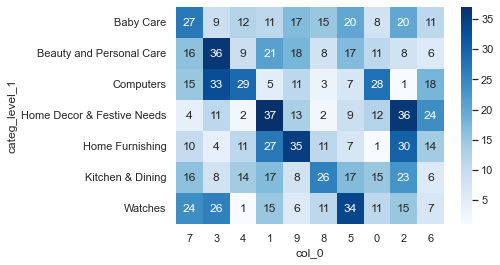

In [101]:
conf_matrix, labelmap = conf_matrix_labels(
    df_data['categ_level_1'], cls.labels_)
# conf_matrix.style.background_gradient(axis=1)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues")


"9.png"


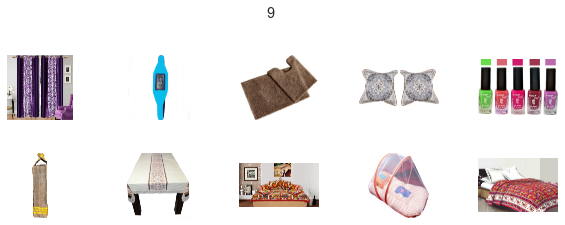

"2.png"


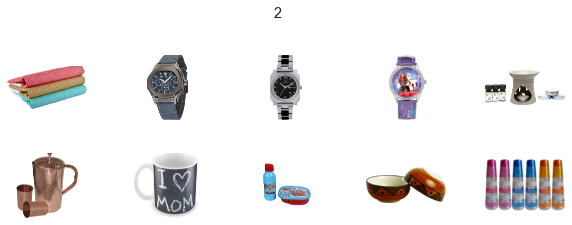

"6.png"


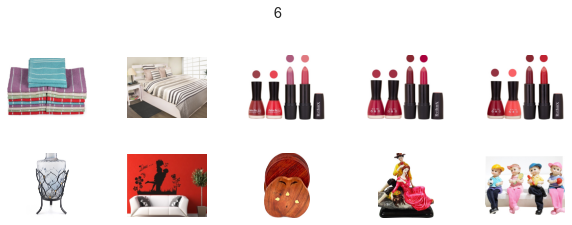

"1.png"


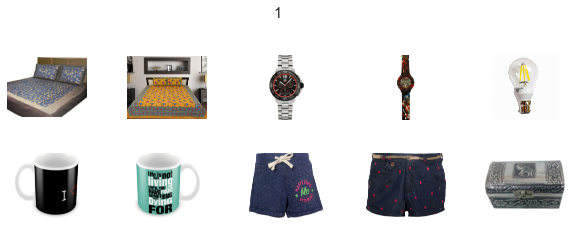

"8.png"


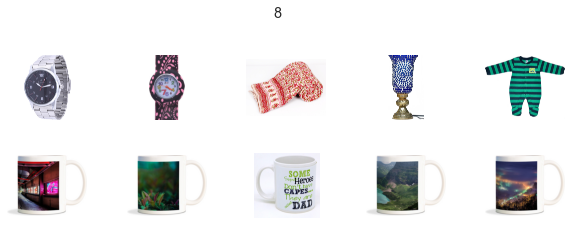

"3.png"


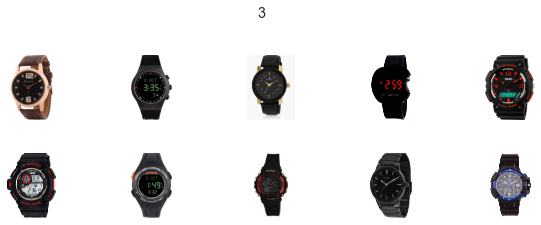

"5.png"


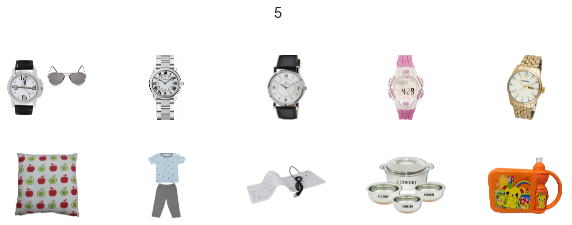

"7.png"


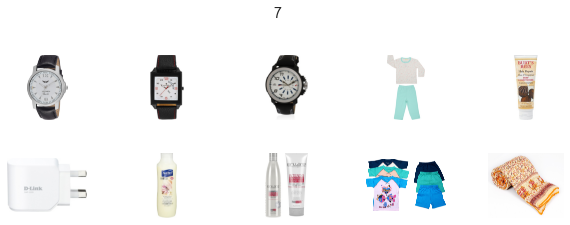

"4.png"


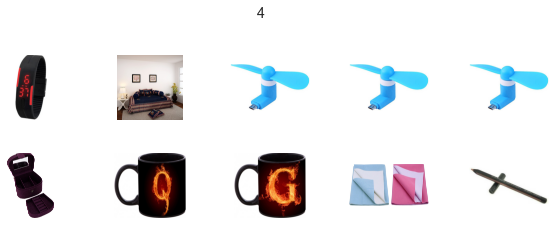

"0.png"


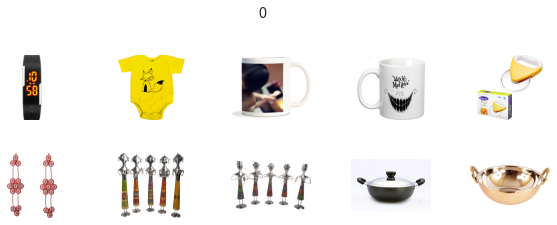

In [102]:
df_data['label_orb'] = cls.labels_
preview_images_by_category(df_data, categ_col='label_orb', nb=10)


In [103]:

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform, zero_division=0))


Correspondance des clusters :  [2 3 3 1 2 6 3 0 5 4]
[[27  9 20 42 17 15 20]
 [16 36 20 35 18  8 17]
 [15 33 57 24 11  3  7]
 [ 4 11 14 97 13  2  9]
 [10  4 12 71 35 11  7]
 [16  8 29 46  8 26 17]
 [24 26 12 37  6 11 34]]

              precision    recall  f1-score   support

           0       0.24      0.18      0.21       150
           1       0.28      0.24      0.26       150
           2       0.35      0.38      0.36       150
           3       0.28      0.65      0.39       150
           4       0.32      0.23      0.27       150
           5       0.34      0.17      0.23       150
           6       0.31      0.23      0.26       150

    accuracy                           0.30      1050
   macro avg       0.30      0.30      0.28      1050
weighted avg       0.30      0.30      0.28      1050



<AxesSubplot:>

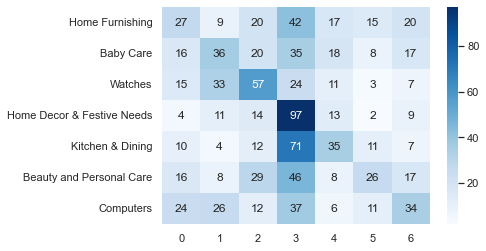

In [105]:
df_cm = pd.DataFrame(conf_mat, index=[label for label in categories],
                     columns=[i for i in "0123456"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")


Visualise images sur t-SNE

- https://nextjournal.com/ml4a/image-t-sne
- https://www.kaggle.com/code/gaborvecsei/plants-t-sne/notebook


In [ ]:
plot_scatter_with_images(X_tsne[:, 0:2], df_data['image'])
plt.title(
    'visualisation des produits sur TSNE pour les top PCA des features ORB', fontsize=24)
to_png()


On voit que certain secteurs de la scatter sont plus foncés que les autres, mais il ne semble pas qu'on a des clusters distincts.


In [ ]:
# supprime les variables utilisé par ORB
del df_tsne
del orb_keypoints_by_img
del orb_keypoints_all
del pca
del feat_pca


# 5. Classification d'images : méthode CNN


## 5.1 Construire un CNN de A à Z avec Tensorflow / Keras

Implémentation de A à Z d'un VGG-16

<!-- <img src="https://cdn-images-1.medium.com/max/1000/1*3-TqqkRQ4rWLOMX-gvkYwA.png"> -->
<img src="./img/Picture1.png">

[Source](https://arxiv.org/abs/1409.1556v6)

<p>
<img src="./img/Picture2.png">

Implémenter un réseau de neurones avec Keras revient à créer un modèle Sequential et à l'enrichir avec les couches correspondantes dans le bon ordre.

L'étape la plus difficile est de définir correctement les paramètres de chacune des couches – d'où l'importance de bien comprendre l'architecture du réseau !

Les couches de convolution, pooling et fully-connected correspondent à des instances des classes respectives `Conv2D,` `MaxPooling2D` et `Dense` du module `keras.layers` . Une couche ReLU peut être créée soit en instanciant la classe `Activation`, soit en ajoutant un argument au constructeur de la couche qui la précède.


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense


def create_VGG16(nb_classes=1000):
    # Création d'un réseau de neurones vide
    model = tf.keras.models.Sequential()

    # Ajout InputLayer pour clarité
    model.add(InputLayer(name='INPUT', input_shape=[224, 224, 3]))

    # -------- Block 1 ----------
    # Ajout de la première couche de convolution, suivie d'une couche ReLU
    # model.add(Conv2D(name='B1_CONV1',input_shape=(224, 224, 3),filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(name='B1_CONV1', filters=64, kernel_size=(
        3, 3), padding='same', activation='relu'))

    # Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
    model.add(Conv2D(name='B1_CONV2', filters=64, kernel_size=(
        3, 3), padding='same', activation='relu'))

    # Ajout de la première couche de pooling
    model.add(MaxPooling2D(name='B1_POOL', pool_size=(2, 2), strides=(2, 2)))

    # -------- Block 2 ----------
    model.add(Conv2D(name='B2_CONV1', filters=128, kernel_size=(
        3, 3), padding="same", activation="relu"))
    model.add(Conv2D(name='B2_CONV2', filters=128, kernel_size=(
        3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(name='B2_POOL', pool_size=(2, 2), strides=(2, 2)))

    # -------- Block 3 ----------
    model.add(Conv2D(name='B3_CONV1', filters=256, kernel_size=(
        3, 3), padding="same", activation="relu"))
    model.add(Conv2D(name='B3_CONV2', filters=256, kernel_size=(
        3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(name='B3_POOL', pool_size=(2, 2), strides=(2, 2)))

    # -------- Block 4 ----------
    model.add(Conv2D(name='B4_CONV1', filters=512, kernel_size=(
        3, 3), padding="same", activation="relu"))
    model.add(Conv2D(name='B4_CONV2', filters=512, kernel_size=(
        3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(name='B4_POOL', pool_size=(2, 2), strides=(2, 2)))

    # -------- Block 5 ----------
    model.add(Conv2D(name='B5_CONV1', filters=512, kernel_size=(
        3, 3), padding="same", activation="relu"))
    model.add(Conv2D(name='B5_CONV2', filters=512, kernel_size=(
        3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(name='B5_POOL', pool_size=(2, 2), strides=(2, 2)))

    # -------- Les couches fully-connected ----------
    model.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

    # Ajout de la première couche fully-connected, suivie d'une couche ReLU
    model.add(Dense(4096, activation='relu'))

    # Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
    model.add(Dense(4096, activation='relu'))

    # Ajout de la dernière couche fully-connected qui permet de classifier
    model.add(Dense(nb_classes, activation='softmax'))
    return model


model = create_VGG16(nb_classes=7)
model.summary()


In [ ]:
# import tensorflow as tf

tf.keras.utils.plot_model(
    model,
    to_file='./img/model_VGG16.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)


### Entrainement d'un model CNN baseline

Le model VGG-16 est un 'deep' learning model, qui prend beaucoup de temps pour chaque epoque, est beaucoup de memoire pour chaque batch.

Avant d'entrainer sur VGG-16, on test rapidement les hyper-parametres de preprocessing en mesurant la perfomance de chaque configuration de preprocessing sur un model plus simple.

- [Image Classification Using Convolutional Neural Networks: A step by step guide](https://www.analyticsvidhya.com/blog/2021/01/image-classification-using-convolutional-neural-networks-a-step-by-step-guide/)


In [ ]:
# import tensorflow as tf


def create_CNN_simple(nb_classes=7):
    model_ = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu,
                               input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2), strides=4),
        tf.keras.layers.Conv2D(
            32, (3, 3), padding='same', activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D((2, 2), strides=4),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(nb_classes,  activation=tf.nn.softmax)
    ])
    return model_


model = create_CNN_simple(len(le.classes_))
model.summary()


## Performance = DATA (preprocess) + MODEL + HYPERPARAMETERS

Le performance d'un model dépend de:

- **preprocess_params** : parametres pour preprocessing des images avant input au model
- **model_params** : paramètres pour construire un model (input shape, preprocessor_layer, nb_classes, nb_layers etc)
- **hyper_params** : paramètres pour éxecuter un model (batch size, optimizer, loss function, metrics, trainable layers etc)

Note: le processing des images peuvent etre fait:

- avant input au model (exemple: réduction de bruit, taille, ou augmentation d'images)
- par les premiers couches du model - (preprocessor layers), avant de transformation par machine learning
- par ajustement des hyperparametres

Avec un pipeline génerique, on peut essayer plusieurs prétraitements, plusieurs models, et finetuning de parametres


## Prepare images for CNN

Il y a plusieurs façons de fournir les données images à un model Keras, qui dépend de la taille des données et la preprocessing exigés:

1. **Charger en memoire** les images (np.array) et leur classifications (image_label), puis train et predict avec ces arrays. Cette méthode est la plus simple (et la plus rapide), car il n'y a pas besoin de gérer des streams.

2. **Mettre les images dans des sous-dossiers** selon leur classe (image_label), et utiliser les fonctions spécialisés de Keras com `tf.keras.utils.image_dataset_from_directory`. Cette methode est utile quand on a besoin d'augmenter le nombre d'images d'entrainement, ou on a besoin d'entrainer un model avec des grands images qui ne peuvent pas être tous chargés en memoire. Mais il faut déplacer les images dans des sous-dossiers selon leur classification.

3. **Créer des tensorflow pipelines** pour traiter les images dans des streams. Cette methode est la plus complexe, car il faut manipuler les streams(flows) de tensors avec des fonctions spécialisés de tensorflow. Il a l'avantage qu'on peut créer les pipelines de data augmentation, par exemple.

4. **Créer un "preprocess_layer" dans le model** : Faire le preprocessing dans un ou plusiers couches du model. L'avantage de cette option c'est que le modèle peut facilement être transporté, car il traite les images brutes (pa besoin de creer un pipeline de preprocessing séparé: on appel simplement `model.predict(img_brute)`)

Pour cette exemple, pour éviter le temps de preprocessement en chaque fit, on créer des données déjà prétraités.

En général, il est recommandé de développer des modèles qui prennent **des données brutes en entrée**, par opposition aux modèles qui prennent des données déjà prétraitées.

- Si votre modèle attend des données prétraitées, chaque fois que vous exportez votre modèle pour l'utiliser ailleurs (dans un navigateur Web, dans une application mobile), vous devrez réimplémenter exactement le même pipeline de prétraitement.

Cela devient très vite très délicat.

**Sources :**

- <https://keras.io/guides/transfer_learning/>
- [Comparison des méthodes (avec exemples)](https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5)
- [Fine tuning pipeline](https://towardsdatascience.com/input-pipeline-for-images-using-keras-and-tensorflow-c5e107b6d7b9)


### Références

#### Image Arrays in memory

- [Image Classification Using Convolutional Neural Networks: A step by step guide](https://www.analyticsvidhya.com/blog/2021/01/image-classification-using-convolutional-neural-networks-a-step-by-step-guide/)
- [Tutorial using tensorflow datasets](https://www.tensorflow.org/tutorials/images/cnn)

#### From flow / image augmentation

- [Codelab : Use convolutional neural networks (CNNs) with complex images](https://developers.google.com/codelabs/tensorflow-5-compleximages)
- [Tutorial Flow from directory (train, test, validation)](https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/)
- [CNN – Image data pre-processing with generators](https://www.geeksforgeeks.org/cnn-image-data-pre-processing-with-generators/)
- <https://algoritmaonline.com/image-classification-cnn/>
- <https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory>

#### Creation de custom tensor flow pipelines

- https://www.tensorflow.org/tutorials/load_data/images
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset
- https://www.tensorflow.org/datasets/splits
- https://www.tensorflow.org/guide/data
- https://www.aitude.com/build-an-image-dataset-in-tensorflow/


## Pipeline = DATA (preprocess) + MODEL + HYPERPARAMETERS

On veut créer un pipeline ou on peut configurer :

- **preprocess_params** : parametres pour preprocessing des images avant input au model
- **model_params** : paramètres pour construire un model (input shape, preprocessor_layer, nb_classes, nb_layers etc)
- **hyper_params** : paramètres pour éxecuter un model (batch size, optimizer, loss function, metrics, trainable layers etc)

Avec un pipeline génerique, on peut essayer plusieurs prétraitements, plusieurs models, et finetuning de parametres


In [ ]:
def run_model_config(df: pd.DataFrame = None,
                     preprocess_fct=None, preprocess_params: dict = None,
                     create_model_fct=None, model_params: dict = None,
                     run_model_fct=None, hyper_params: dict = None):
    data, model, history = None, None, None
    if not preprocess_fct is None:
        # preprocess data, based on preprocess configuration dictionary
        data = preprocess_fct(df, **preprocess_params)
    if not create_model_fct is None:
        # create model, based on model_params
        model = create_model_fct(**model_params)
    if not run_model_fct is None:
        # fit model, based on
        model, history = run_model_fct(model, **hyper_params)

    return data, model, history


In [ ]:
# Example

_, model, _ = run_model_config(
    create_model_fct=create_VGG16, model_params=dict(nb_classes=7))
print(model.layers[0].input)
print(model.layers[-1].output)


### Les catégories

Les label names sont encodés par ordre alphabétique


In [ ]:
# from sklearn import preprocessing
LABEL_COL = 'categ_level_1'
le = preprocessing.LabelEncoder()
le.fit_transform(sorted(list(df_data[LABEL_COL].unique())))


In [ ]:
print(le.classes_)


## Creation de jeu de données train, validation (et optionellement, test)

Les données d'entrée dans les models tensorflow sont des datasets composée de tensors

On a plusieurs façons de les crées : - from numpy_array (images en memoire) - images_from_directory (images dans des sous_dossiers de class_label) - flow_from_directory (comme directory, mais permet d'ajouter des preprocessing_functions) - flow_from_dataframe (images dans une seul dossier)


### Datasets from numpy_array

- Permet de finetune le preprocessing des images (reduction de bruit, equalize, contrast etc)


#### Charger les images dans mémoire

Ce jeux de données est pétit (1050 images).
Si on utilise 224px _ 224px _ 3 channels (float32),

- chaque image prend environ 224 _ 224 _ 3 \* 4 bytes = moins de 1Mo d'espace,
- donc un total de < 1Go RAM

On peut charger les images en mémoire

Pour traiter les datasets plus gros, j'ai ajouté 4 lignes (if save_to_dir!=None), qui permet de placer les images préparés dans des sous-dossiers selon leur classification (labels)


In [ ]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
# from PIL import Image

def load_image_data(df: pd.DataFrame, label_col='categ_level_1', filename_col='image',
                    target_size=(224, 224), preprocess_params=None, image_dir=IMG_FOLDER, verbose=False, save_to_dir=None):
    """Charger les images, prétraiter et stocker en memoire, 
    ou (if save_to_dir!=None), placer les images préparés 
    dans des sous-dossiers selon leur classification
    """

    start = time.time()
    images = []
    filenames = list(df[filename_col])
    labels = list(df[label_col])

    max_pixels = Image.MAX_IMAGE_PIXELS
    Image.MAX_IMAGE_PIXELS = 93680328+1
    nb = len(filenames)
    for i, filename in enumerate(filenames):
        if verbose and i > 0 and i % 100 == 0:
            print(f'process {i} of {nb} images')
        filepath = f'{image_dir}/{filename}'
        if preprocess_params is None:
            # Fast preprocessing, but lower resolution
            img_array = np.array(tf.keras.preprocessing.image.load_img(
                filepath, target_size=target_size))
        else:
            img_array = np.array(Image.open(filepath))
            img_array = img_preprocess(img_array, params=preprocess_params)
            if not isinstance(img_array, np.ndarray):
                img_array = np.array(img_array)
            if len(img_array.shape) != 3:
                img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
            if (img_array.shape[0], img_array.shape[1]) != target_size:
                # être sur que l'image est de la bonne taille
                img_array = cv2.resize(
                    img_array, target_size, interpolation=Image.ANTIALIAS)

        if save_to_dir is None:
            images.append(img_array)
        else:
            class_label = sanitize(labels[i])
            savepath = f'{save_to_dir}/{class_label}'
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            tf.keras.preprocessing.image.save_img(
                path=f'{savepath}/{filename}', x=img_array,)

    Image.MAX_IMAGE_PIXELS = max_pixels
    image_processing_time = time.time()-start
    print(f'image_processing_time : {image_processing_time:.1f} s')
    return images, labels, filenames


# PREPROCESS_PARAMS={'resize':{'sq_size':224},'equalize':True,'squarify':True}
PREPROCESS_PARAMS = None
# image_data = load_image_data(df_data, preprocess_params=PREPROCESS_PARAMS, verbose=True, save_to_dir='/data/preprocessed')
image_data = load_image_data(
    df_data, preprocess_params=PREPROCESS_PARAMS, verbose=True)


### Create X and y from image data

les noms des fichiers sont suivis dans le variable z pour faciliter l'investigation des erreurs de classification


In [ ]:
from typing import Tuple


def split_image_data(image_data_: Tuple):
    X_, y_, z_ = image_data_
    return np.array(X_), np.array(y_), np.array(z_)


X, y, z = split_image_data(image_data)


In [ ]:
def naturalsize(bytes: int or float):
    suffix = ['kB', 'MB', 'GB', 'TB', 'PB']
    for i, s in enumerate(suffix):
        unit = 1024 ** (i + 2)
        if bytes < unit:
            return (f'{(1024 * bytes / unit):.1f} {s}')


X = np.array(X)
print(np.array(X).shape)
naturalsize(np.array(X).nbytes)


### reshape X and normalise X values

Le fit des modèles est plus rapide si les valeurs de X sont normalisés

- les valeurs X sont entiers entre 0 est 255
- la modèle attend des valeurs float32 normalisés

On utilise preprocessing pour les normaliser

- [Best Practices for Preparing and Augmenting Image Data for CNNs](https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/)


In [ ]:
# import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.applications import imagenet_utils


def preprocess_input_caffe(x):
    """convert images from RGB to BGR, then zero-center each color channel with
          respect to the ImageNet dataset, without scaling.
    """
    return imagenet_utils.preprocess_input(x, mode='caffe')


def preprocess_input_tf(x):
    """ scale pixels between -1 and 1, sample-wise. ( x /= 127.5 ;x -= 1.)
      """
    return imagenet_utils.preprocess_input(x, mode='tf')


def preprocess_input_torch(x):
    """scale pixels between 0 and 1, (x /= 255), then normalize each channel with respect to the
          ImageNet dataset.
    """
    return imagenet_utils.preprocess_input(x, mode='torch')


def reshape_normalise(x_, img_size=224):
    x_ = np.array(x_).reshape(-1, img_size, img_size, 3)
    print(
        f'X (avant preprocess), shape= {x_.shape}, size={naturalsize(x_.nbytes)}')
    # normalise
    x_ = preprocess_input_tf(x_)
    print(
        f'X (après preprocess), shape= {x_.shape}, size={naturalsize(x_.nbytes)}')
    return x_


X = reshape_normalise(X, 224)


### Transform y to categorical

Encodage des class_names, puis création d'un array de longuer egal au nombre de classes


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.utils import to_categorical


def labels_to_categorical(labels_, label_encoder):
    label_encoded = label_encoder.transform(labels_)
    ohe = tf.keras.utils.to_categorical(label_encoded, len(le.classes_))
    return ohe


print(f'sample labels : {y[0:6]}')
Y = labels_to_categorical(y, label_encoder=le)
print(Y.shape)
print(f'sample encode : {Y[0:6]}')


#### Visualise un image


In [ ]:
plt.imshow(X[0])
plt.title(z[0])
plt.suptitle(get_product_name_from_filename(df_data, z[0]))


### Train test split

On ajout la list de filenames


In [ ]:
# from sklearn.model_selection import train_test_split

# Create a test set
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(
    X, Y, z, test_size=0.2, random_state=RANDOM_SEED)


### Choix de loss function

si on veut savoir les probabilités de classification:

- y = ohe_encode (labels)
- loss= categorical_crossentropy ,
- les predictions du model affiche les poids sur chaque catégorie,

Si on veut le plus probable classification:

- y = label_encode(labels)
- loss = sparse_categorical_crossentropy
- les predictions du model affiche argmax des categories encodés

References

- https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
- https://machinelearningmastery.com/cross-entropy-for-machine-learning/

### Choix d'optimizer

Adam: Adaptive moment estimation

- https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6
- https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e


### Fit model

Premier pas: savoir les probailités de classification, pour savoir si la classification est proche ou loin

Si on utilise sparse_categorical_crossentropy, on n'a pas accès a cette information


In [ ]:
PREPROCESS_PARAMS = None
image_data = load_image_data(df_data, preprocess_params=PREPROCESS_PARAMS)
X, y, z = split_image_data(image_data)
X = preprocess_input_tf(X)
# for categorical_crossentropy, use ohe encoding,
# for sparse_categorical_cross_entropy, use label_encoding
Y = labels_to_categorical(y, le)
# split entre train 80% et validation (20%)
x_train, x_val, y_train, y_val, z_train, z_val = train_test_split(
    X, Y, z, test_size=0.2, random_state=RANDOM_SEED)
# si besoin, on peut diviser validation en 2 (validation 10% et test 10%):
x_val, x_test, y_val, y_test, z_val, z_test = train_test_split(
    x_val, y_val, z_val, test_size=0.5, random_state=RANDOM_SEED)

model = create_CNN_simple(nb_classes=7)
# categorical_crossentropy :  les % dans chaque category
# sparse_categorical_crossentropy :  le category avec la plus grand poid
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
batch_size = 32
nb_epochs = 10

history = model.fit(x_train, y_train, batch_size=batch_size,
                    epochs=nb_epochs, verbose=1, validation_data=(x_val, y_val))


## Evolution de l'historique

- https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/


In [ ]:
# list all data in history
print(history.history.keys())


In [ ]:

def plot_diagnostic_learning_curves(history):
    """Plot summary diagnostics from history of model training"""
    colors = sns.color_palette('tab10')
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # plot loss
    ax1 = axs[0]
    ax1.set_title('Cross Entropy Loss')
    ax1.plot(history.history['loss'], c=colors[0], label='train')
    ax1.plot(history.history['val_loss'], c=colors[1], label='validate')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.legend()
    # plot accuracy
    ax2 = axs[1]
    ax2.set_title('Classification Accuracy')
    ax2.plot(history.history['accuracy'], c=colors[0], label='train')
    ax2.plot(history.history['val_accuracy'], c=colors[1], label='validate')
    ax2.legend()
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('accuracy')
    fig.suptitle('Loss and accuracy evolution over epochs')


plot_diagnostic_learning_curves(history)


On voit que l'exactitude du model sur les données test n'ameliore pas significativement après 5 époques : - Le model fait d'overfitting sur les données d'entrainement

- le cross-entropy loss n'est pas réduit

On n'attend pas une amélioration significatif du modèle avec plus d'entrainement


# Accuracy and Score of model

On test avec les données qui ont jamais étais vu par le modèle


In [ ]:
score = model.evaluate(x_val, y_val, verbose=0)
print(f'Validation score (entropy): {score[0]:.3f}')
print(f'Validation accuracy: {round(score[1]*100,1)} %')


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test score (entropy): {score[0]:.3f}')
print(f'Test accuracy: {round(score[1]*100,1)} %')


In [ ]:
val_pred = model.predict(x_test)
val_true = y_test
print(val_pred.shape, val_true.shape)


In [ ]:
val_true[0:5]


In [ ]:
val_true.argmax(axis=1)[0:5]


Le model a un accuracy d'environ 50%, qui n'est pas amélioré avec plus d'epochs


In [ ]:
def cnn_results(filenames, y_true, y_pred, label_encoder):
    """
    Convertir les donnees X (pixels) et labels y (0...n) en forme comprehensible:
    Parameters
    ----------
    filenames   nom du fichier de l'image representé par X
    y_true      label_encoded version de true label
    y_pred      label_encoded version des predictions
    label_encoder : l'encoder utiliser pour convertir

    Returns
    -----------
    - l'inverse transform des labels y, associe a chaque image répresenté par X"""
    y_pred_pct = np.round(y_pred*100, 2)
    s_filenames = pd.Series(filenames, name='filename')
    s_true = pd.Series(label_encoder.inverse_transform(
        y_true.argmax(axis=1)), name='label_true')
    s_pred = pd.Series(label_encoder.inverse_transform(
        y_pred.argmax(axis=1)), name='label_pred')
    s_prob_pred = pd.Series(y_pred_pct.max(axis=1), name='prob_pred')
    df_pred = pd.DataFrame(y_pred_pct, columns=label_encoder.classes_)
    return pd.concat([s_filenames, s_true, s_pred, s_prob_pred, df_pred], axis=1)


df_val_pred = cnn_results(z_val, val_true, val_pred, le)
df_val_pred.head()


In [ ]:
# from sklearn import metrics
conf_matrix = pd.DataFrame(metrics.confusion_matrix(
    df_val_pred['label_true'], df_val_pred['label_pred']), index=le.classes_)
conf_matrix.style.background_gradient()


In [ ]:
# from sklearn import metrics
ARI1 = metrics.adjusted_rand_score(
    df_val_pred['label_true'], df_val_pred['label_pred'])
print(f'ARI score = {ARI1}')


In [ ]:

plot_sankey_confusion_diagram(
    df_val_pred['label_true'], df_val_pred['label_pred'], palette='Dark2')


On regard les prédictions pour toutes les données


In [ ]:
val_pred = model.predict(X)
val_true = Y
print(val_pred.shape, val_true.shape)


In [ ]:
df_val_pred = cnn_results(z, val_true, val_pred, le)
df_val_pred.head()


In [ ]:
plot_sankey_confusion_diagram(
    df_val_pred['label_true'], df_val_pred['label_pred'], palette='Dark2')


On regard les images mal-classés


In [ ]:
def get_wrongly_classed(df, true_col='label_true', pred_col='label_pred', probability_col='prob_pred'):
    return df[df[true_col] != df[pred_col]].sort_values(by=[probability_col], ascending=False)


wrong_class = get_wrongly_classed(df_val_pred)
wrong_class.head()


Visualise badly classed products


In [ ]:
def label_probability(row):
    label_pred = row['label_pred']
    prob_pred = row['prob_pred']
    return f'{label_pred} ({prob_pred:.0f} %)'


images = list(wrong_class['filename'][:10])
titles = list(wrong_class.head(10).apply(label_probability, axis=1))
print(images)
print(titles)
preview_images(images, titles, 'Mal classés')


In [ ]:
# cleanup
del model
del history
tf.keras.backend.clear_session()


# Repete, mais avec sparse_category


In [ ]:
# from sklearn.model_selection import train_test_split
PREPROCESS_PARAMS = None
image_data = load_image_data(df_data, preprocess_params=PREPROCESS_PARAMS)
X, y, z = split_image_data(image_data)
# normalise X (valeurs entre -1 et 1)
X = preprocess_input_tf(X)
# encode class labels
Y = le.transform(y)
# split entre train 80% et validation (20%)
x_train, x_val, y_train, y_val, z_train, z_val = train_test_split(
    X, Y, z, test_size=0.2, random_state=RANDOM_SEED)
# si besoin, on peut diviser validation en 2 (validation 10% et test 10%):
# x_val,x_test,y_val,y_test, z_val, z_test =train_test_split(x_val,y_val,z_val,test_size=0.5, random_state=RANDOM_SEED)

model = create_CNN_simple(nb_classes=7)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
batch_size = 32
nb_epochs = 10

history = model.fit(x_train, y_train, batch_size=batch_size,
                    epochs=nb_epochs, verbose=1, validation_data=(x_val, y_val))


In [ ]:
plot_diagnostic_learning_curves(history)


In [ ]:
# Cleanup
del history

# import tensorflow as tf
del model
tf.keras.backend.clear_session()


## Dataset tensors : moyennes de créer des datasets hors memoire

Ici on utilise les datsets en memoire, pour être plus rapide.

La plupart de temps on ne peut pas traiter toute les données au même temps. Il faut traiter iterativement

ci dessous, les procedures avec tensor datasets

- La procedure from


In [ ]:

# from sklearn.model_selection import train_test_split

def datasets_from_numpy(images, labels, filenames, label_encoder=None, loss='categorical_crossentropy', stratified=False):
    if stratified:
        x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(
            images, labels, filenames, train_size=0.2, stratify=labels, random_state=RANDOM_SEED)
    else:
        x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(
            images, labels, filenames, train_size=0.2, random_state=RANDOM_SEED)

    if label_encoder:
        if loss == 'sparse_categorical_crossentropy':
            # if using loss='ca
            y_train = label_encoder.transform(y_train)
            y_test = label_encoder.transform(y_test)
        else:
            y_train = labels_to_categorical(y_train, label_encoder)
            y_test = labels_to_categorical(y_test, label_encoder)

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    return train_ds, test_ds


def fit_model_from_numpy(model_, images_, labels_, filenames_, label_encoder=None, loss=None, batch_size=32, nb_epochs=1, stratified=False):

    train_ds, test_ds = datasets_from_numpy(
        images_, labels_, filenames_, label_encoder, loss=loss, stratified=stratified)
    SHUFFLE_BUFFER_SIZE = 100
    train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
    test_ds = test_ds.batch(batch_size)
    history = model_.fit(train_ds, epochs=nb_epochs,
                         validation_data=test_ds)
    return history, model_

# ---------------------------------------
# Fine tuning of preprocessing


# PREPROCESS_PARAMS={'resize':{'sq_size':224},'equalize':True,'squarify':True}
# PREPROCESS_PARAMS={'resize':{'sq_size':224},'equalize':True,'squarify':False}
# PREPROCESS_PARAMS=None
MODEL_PARAMS = dict(loss='sparse_categorical_crossentropy')
# image_data = load_image_data(df_data, preprocess_params=PREPROCESS_PARAMS)
X, y, z = split_image_data(image_data)
X = preprocess_input_tf(X)
model = create_CNN_simple(nb_classes=7)
model.compile(optimizer='adam',
              loss=MODEL_PARAMS['loss'], metrics=['accuracy'])
history, model = fit_model_from_numpy(model, X, y, z, label_encoder=le, loss=MODEL_PARAMS['loss'],
                                      stratified=True, nb_epochs=10)


In [ ]:
plot_diagnostic_learning_curves(history)


In [ ]:
# cleanup
del model
del history
tf.keras.backend.clear_session()


### Datasets (train, test) from DataFrame

Si les images en memoire (comme array numpy) sont trop grand, tensor flow inclut un fonction pour charger les images à partir d'un dataframe.
Ci-dessous, le preprocessing est fait pendant stream, ce qui fait que les données sont préprocessés à chaque epoch.


In [ ]:
# import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def datasets_from_df(df: pd.DataFrame,
                     preprocess_fct=preprocess_input_torch, image_size=(224, 224), batch_size=32, flow_params={}):

    dataset_params = dict(
        x_col='image', y_col='categ_level_1',
        directory=IMG_FOLDER,
        # comment cette ligne si on ne veut pas sauvegarder les images
        # save_to_dir='data/out/generated', save_format='jpg',
        class_mode='categorical', batch_size=batch_size, target_size=image_size)

    if not flow_params is None:
        dataset_params = dict(**dataset_params, **flow_params)

    if 'dataset' in df.columns:
        # Use stratified split des categories
        train_df = df[df['dataset'] == 'train']
        validation_df = df[df['dataset'] == 'validation']

        datagen = ImageDataGenerator(
            preprocessing_function=preprocess_fct,
            # target_size=image_size,
        )
        train_ds = datagen.flow_from_dataframe(train_df, **dataset_params)
        validation_ds = datagen.flow_from_dataframe(
            validation_df, **dataset_params)

    else:
        # non-stratified split
        datagen = ImageDataGenerator(
            preprocessing_function=preprocess_fct,
            # target_size=image_size,
            validation_split=0.2,
        )
        train_ds = datagen.flow_from_dataframe(
            df, subset='training', **dataset_params)
        validation_ds = datagen.flow_from_dataframe(
            df, subset='validation', **dataset_params)

    return train_ds, validation_ds


def fit_model_from_dataframe(model_, df, preprocess_fct=preprocess_input_tf, image_size=(224, 224),
                             batch_size=32, nb_epochs=1, flow_params=None):
    train_ds, test_ds = datasets_from_df(df, preprocess_fct=preprocess_fct,
                                         image_size=image_size, batch_size=batch_size)

    history = model_.fit(train_ds, epochs=nb_epochs, validation_data=test_ds)
    return history, model_

# ---------------------------------------
# Fine tuning of preprocessing


# PREPROCESS_PARAMS={'resize':{'sq_size':224},'equalize':True,'squarify':True}
# PREPROCESS_PARAMS={'resize':{'sq_size':224},'equalize':True,'squarify':False}
MODEL_PARAMS = dict(
    preprocess_fct=preprocess_input_tf,
    flow_params=dict(x_col='image', y_col='categ_level_1',
                     directory=IMG_FOLDER,
                     # comment cette ligne si on ne veut pas sauvegarder les images
                     # save_to_dir='data/out/generated', save_format='jpg',
                     class_mode='categorical', target_size=(224, 224))
)
model = create_CNN_simple(nb_classes=7)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
# Beaucoup plus long
# history, model = fit_model_from_dataframe(
#     model, df_data, **MODEL_PARAMS, nb_epochs=5)


On voit que le accuracy du model est haut, mais la validation est bas.

Peut-être c'est parce qu'on n'a pas fait un split stratifié.


### Dataset from directory (with flow)

Dataset from dataframe est lent et pas très parametrable.

Si nos données sont déjà placés dans les dossiers de chaque classe, on peut creer des datasets sans besoin d'un dataframe

La plupart des exemples utilise ce methode, qui n'est pas la plus adaptée à notre jeu de données

- Dans une autre notebook j'ai mis en oeuvre une series de procedures pour
  - Stratified split (optionnel):
    - split df entre df_train, df_valid, df_test
    - creer/remplacer des dossiers train, valid, test pour recevoir les images
  - Pour chaque dataset, preprocess les images(si besoin) et les mettre dans des sous dossiers en accord avec leur class_label
  - creer des datasets à partir de ces images

avantage: on peut utiliser

- from tensorflow.keras.applications.model_name import preprocess_input, decode_predictions; ou
- from tensorflow.keras.applications.imagenet_utils import decode_predictions


### Nettoye memoire


In [ ]:
# Cleanup

# import tensorflow as tf
# del history
del model
tf.keras.backend.clear_session()


# Transfer learning


# My VGG-16 model

Ce model est très lent àn entrainé avec les données en memoire (environ 20 minutes par époch)


In [ ]:
def test_my_vgg16(x_train_, y_train_, x_val_, y_val_, label_encoder, x_test_=None, y_test_=None):
    model_VGG16 = create_VGG16(nb_classes=len(label_encoder.classes_))
    model_VGG16.compile(
        optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    batch_size = 32
    nb_epochs = 1
    history = model_VGG16.fit(x_train_, y_train_, batch_size=batch_size, epochs=nb_epochs,
                              verbose=1, validation_data=(x_val_, y_val_))

    if nb_epochs > 2:
        plot_diagnostic_learning_curves(history)

    score = model_VGG16.evaluate(x_val_, y_val_, verbose=0)
    print(f'Validation score (entropy): {score[0]:.3f}')
    print(f'Validation accuracy: {round(score[1]*100,1)} %')

    score = model_VGG16.evaluate(x_test_, y_test_, verbose=0)
    print(f'Test score (entropy): {score[0]:.3f}')
    print(f'Test accuracy: {round(score[1]*100,1)} %')


image_data = load_image_data(df_data, preprocess_params=PREPROCESS_PARAMS)
X, y, z = split_image_data(image_data)
# normalise X (valeurs entre -1 et 1)
X = preprocess_input_tf(X)
# encode class labels
Y = le.transform(y)
# split entre train 80% et validation (20%)
x_train, x_val, y_train, y_val, z_train, z_val = train_test_split(
    X, Y, z, test_size=0.2, random_state=RANDOM_SEED)
# si besoin, on peut diviser validation en 2 (validation 10% et test 10%):
x_val, x_test, y_val, y_test, z_val, z_test = train_test_split(
    x_val, y_val, z_val, test_size=0.5, random_state=RANDOM_SEED)

# test_my_vgg16(x_train,y_train,x_val,y_val, le, x_test,y_test)


Après 13 minutes (1 epoch) :

```text
image_processing_time : 12.3 s
27/27 [==============================] - 721s 27s/step - loss: 4.6106 - accuracy: 0.1440 - val_loss: 1.9441 - val_accuracy: 0.1143
Validation score (entropy): 1.944
Validation accuracy: 11.4 %
Test score (entropy): 1.956
Test accuracy: 8.6 %
```


Il va prendre du temps à entrainer cette modèle avec nos 1000 images, et probablement il faut augmenter les images

On va accélerer l'apprentissage avec Transfer Learning


## Predict with pretrained image classes

Depuis la création de VGG-16 en 2014, il y aura des avancements de performance

- https://paperswithcode.com/sota/image-classification-on-imagenet

- https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
- https://stackabuse.com/image-classification-with-transfer-learning-in-keras-create-cutting-edge-cnn-models/


In [ ]:
# import tensorflow as tf
tf.keras.backend.clear_session()

# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', include_top=True, input_shape=(224, 224, 3))


In [ ]:
# import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
# load an image from file
file = f"{wrong_class['filename'].iloc[3]}"
image = load_img(f'{IMG_FOLDER}/{file}', target_size=(224, 224))
preview_image(img=image)
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# preprocess_input, decode_predictions
from tensorflow.keras.applications import vgg16

# load the model
# model = VGG16()
# load an image from file
file = f"{wrong_class['filename'].iloc[3]}"
FILES = list(df_data['image'])


def predict_image(filename=None, model=model, decoder_fct=vgg16.decode_predictions, file_path=IMG_FOLDER, preview=False):
    """Prédire une image(enregistré dans IMG_FOLDER) avec un model, utilisant """
    if filename is None:
        filename = np.random.choice(FILES)
    if file_path is None:
        image = load_img(filename, target_size=(224, 224))
    else:
        image = load_img(f'{file_path}/{filename}', target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = vgg16.preprocess_input(image)
    # predict the probability across all output classes
    yhat = model.predict(image)
    # convert the probabilities to class labels
    try:
        label = decoder_fct(yhat)
        # retrieve the most likely result, e.g. highest probability
        label = label[0][0]
        # print the classification
        classification = f'{label[1]} ({(label[2]*100):.0f}%)'
        print(classification)
    except:
        print(yhat)
    if preview:
        preview_image(filename=filename)


predict_image(FILES[1], preview=True)


In [ ]:
predict_image(FILES[8], preview=True)


In [ ]:
predict_image(FILES[50], preview=True)


Il semble que VGG16, pré-entrainé sur ImageNet, est bien capable de classifier nos images.

On voit si le model entrainé est capable de faire de catégorisation non-supervisée (semi-supervisée car il utilise les 1000 catégories d'ImageNet)


# Image Clustering (non-supervisée) avec VGG-16

On peux faire du clustering (semi-supervisée) sur cette modele VGG-16 (entrainé sur nos images) pour trouvé des clusters similaires aux catégories

Si on ne veut pas utilisé les catégories fournis, on peut utilisé les features de VGG-16 (entrainé sur ImageNet) pour des nouveaux categories

- https://towardsdatascience.com/image-clustering-using-k-means-4a78478d2b83


In [ ]:
df_image_labels = df_data[['image', 'categ_level_1']].copy()
df_image_labels['file'] = IMG_FOLDER + '/' + df_image_labels['image']
df_image_labels.head()


In [ ]:
filelist = list(df_image_labels['file'])
print(filelist[:3])


In [ ]:


predict_image(filelist[0], model, file_path=None)


In [ ]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import pickle


def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224, 224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1, 224, 224, 3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    # features = model.predict(imgx, use_multiprocessing=True)
    features = model.predict(imgx, use_multiprocessing=True)
    return features

# extract_features(filelist[0],model)


In [ ]:
def extract_all_features(filelist, model, nb=100, pickle_location='data/out/features.pkl'):

    data = {}

    # Location to save features
    p = pickle_location

    nb = min(nb, len(filelist))
    nb_10 = nb//10

    imagelist = filelist[:nb]
    nb = len(imagelist)

    # lop through each image in the dataset
    start = time.time()
    for i, image in enumerate(imagelist):
        if (i % nb_10) == 0:
            if i > 0:
                taken = time.time()-start
                percent_done = i/nb
                total_time = taken/percent_done
                ETA = total_time-taken
                print(
                    f'{taken:.0f}s. (ETA: {ETA:.0f}s); extract_features : {i} of {nb}')
        # try to extract the features and update the dictionary
        try:
            feat = extract_features(image, model)
            data[image] = feat
        # if something fails, save the extracted features as a pickle file (optional)
        except:
            with open(p, 'wb') as file:
                pickle.dump(data, file)

    # get a list of the filenames
    filenames = np.array(list(data.keys()))

    # get a list of just the features
    feat = np.array(list(data.values()))

    feat = feat.reshape(len(filenames), -1)
    print(feat.shape)
    return feat, filenames


feat, filenames = extract_all_features(filelist, model, nb=1050)


In [ ]:
save_pickle(feat, 'features_vgg16', OUT_FOLDER)


In [ ]:
from keras.applications.vgg16 import decode_predictions


def pred_categories(files, model, image_labels: pd.DataFrame = df_image_labels):
    for file in files:
        features = extract_features(file, model)
        nb = min(len(files), 10)
        if features.shape[1] == 1000:
            # output is same shape as number of categories in ImageNet
            y_pred = decode_predictions(feat, top=1)
            if not image_labels is None:
                y_true = image_labels['categ_level_1']
                for i in range(0, nb):
                    # print(f'{y_true[i]} \t {y_pred[i]} ')
                    _, pred, weight = y_pred[i][0]
                    print(f'{y_true[i]} \t {pred} ({weight*100:.0f}%)')
        else:
            y_pred = np.argmax(feat, axis=1)
        return y_pred


_ = pred_categories(filelist[:5], model)


In [ ]:
print(filelist[:5])


In [ ]:
print(list(df_image_labels['file'])[:5])


In [ ]:
# Reduction de dimensions
feat_pca = reducer_pca(feat)
k = len(categories)

# reduction en 2 dimensions tsne, cluster par KMeans, calcul de similarité
ARI_vgg, X_tsne, labels_vgg = calc_tsne_cluster(
    feat_pca, categories, y_cat_num, k)


Cherche le meilleur nombre de clusters


In [ ]:
search_params = {'n_clusters': range(4, 15)}
scores_vgg, labels_vgg = score_kmeans(
    X_tsne, param_grid=search_params, labels_true=df_data['categ_level_1'])
scores_vgg.head()


In [ ]:
plot_metrics(scores_vgg)


On voit la meilleur nombre de clusters trouvés par vgg16 est avec k=7

On visualise sur t-SNE


In [ ]:
plot_clusters_sur_2D(X_tsne, y_cat_num, labels_vgg, ARI_vgg)
plt.suptitle(
    f'Clustering non-supervisée sur VGG-16, feature reduction: PCA + TSNE (ARI = {ARI_vgg:.3f})')
to_png()


Visualise images sur t-SNE


In [ ]:
plot_scatter_with_images(X_tsne, df_data['image'])
plt.title('Produits sur TSNE pour clusters des features VGG-16', fontsize=24)
to_png()


In [ ]:
def fit_clusters(df, features, k=7):
    cls = cluster.KMeans(n_clusters=k)
    cls.fit(features)
    df = df.copy()
    df['cluster_id'] = cls.labels_
    return df


df_clusters = fit_clusters(features=X_tsne, df=df_image_labels)
df_clusters.head()


In [ ]:

# function that lets you view a cluster (based on identifier)
def view_cluster(df: pd.DataFrame, cluster_id=0, nb=10):
    plt.figure(figsize=(25, 25))
    # gets the list of filenames for a cluster
    mask = df['cluster_id'] == cluster_id
    files = list(df[mask]['file'])

    # only allow up to 30 images to be shown at a time
    if len(files) > nb:
        print(f"Clipping cluster size from {len(files)} to {nb}")
        files = files[:nb]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10, 10, index+1)
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')


for i in range(7):
    view_cluster(df_clusters, cluster_id=i)
    plt.suptitle(
        f'Clusters classifiées par VGG16 : images de cluster no. [{i}]', fontsize=24)
    to_png()
    plt.show()


In [ ]:
# Clean up
del model
tf.keras.backend.clear_session()


## Clustering non-supervisée sans les premiers 2 couches de VGG16

Les derniers couches de VGG16 dirige les images vers les classes d'ImageNet

On peut verifier si on peut améliorer la résultat de classification en supprimant des couches


In [ ]:
# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)


In [ ]:
# feat will be a matrix of shape [1050, 4096]
feat, filenames = extract_all_features(filelist, model, nb=1050)


In [ ]:
save_pickle(feat, 'features_vgg16_2', OUT_FOLDER)


In [ ]:
# Reduction de dimensions
feat_pca = reducer_pca(feat)
categories = y_cat_txt.unique()
k = len(categories)

# reduction en 2 dimensions tsne, cluster par KMeans, calcul de similarité
ARI_vgg2, X_tsne, labels_vgg2 = calc_tsne_cluster(
    feat_pca, categories, y_cat_num, k)


In [ ]:
search_params = {'n_clusters': range(4, 15)}
scores_vgg2, labels_vgg2 = score_kmeans(
    X_tsne, param_grid=search_params, labels_true=df_data['categ_level_1'])
plot_metrics(scores_vgg2)


In [ ]:
plot_clusters_sur_2D(X_tsne, y_cat_num, labels_vgg2, ARI_vgg2)
plt.suptitle(
    f'Clustering non-supervisée sur VGG-16 moins 2 couches, feature reduction: PCA + TSNE (ARI = {ARI_vgg2:.3f})')
to_png()


In [ ]:
plot_scatter_with_images(X_tsne, df_data['image'])
plt.title(
    'Produits sur TSNE pour clusters des features VGG-16 (moins 2 couches)', fontsize=24)
to_png()


In [ ]:
cls_labels_transform = conf_mat_transform(y_cat_num, labels_vgg2)
conf_mat = metrics.confusion_matrix(y_cat_num, cls_labels_transform)
print(conf_mat)

print(metrics.classification_report(
    y_cat_num, cls_labels_transform, target_names=categories, zero_division=0))


In [ ]:
list_labels = categories
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[i for i in "0123456"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.0f')


In [ ]:
matr, _ = conf_matrix_labels(y_cat_txt, labels_vgg2)
matr.style.background_gradient()


En supprimant les dernieres couches, nous avons amélioré le modele.


In [ ]:
# Cleanup
# import tensorflow as tf
del model
tf.keras.backend.clear_session()


# Transfer Learning

- Stratégie #1 : fine-tuning total
- Stratégie #2 : extraction de features
- Stratégie #3 : fine-tuning partiel

### Réferences

- https://keras.io/guides/transfer_learning/
- https://keras.io/api/applications/#usage-examples-for-image-classification-models
- https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/


### Using random data augmentation

- https://keras.io/guides/transfer_learning/

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1), ]
)


In [ ]:
import numpy as np
row = 143
image_data = load_image_data(
    df_data.loc[row:row+5, :], preprocess_params=PREPROCESS_PARAMS)
images, labels, z = split_image_data(image_data)
# images = preprocess_input_tf(images)

# for images, labels in train_ds.take(1):
plt.figure(figsize=(10, 10))
first_image = images[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(
        tf.expand_dims(first_image, 0), training=True
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.title(labels[0])
    plt.axis("off")

plt.suptitle('Data augmentation')
to_png()


## Create model


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Model

tf.keras.backend.clear_session()


def create_vgg16_transfer_model(nb_clusters=7, input_shape=(224, 224, 3)):
    """Créer un model vgg16 pré-entraîné sur ImageNet, prêt pour transfer learning"""
    # Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
    # Load weights pre-trained on ImageNet.
    # Do not include the ImageNet classifier at the top.
    base_model = VGG16(weights="imagenet", include_top=False,
                       input_shape=input_shape)

    # freeze the base model (stops us from setting any individual layer as trainable)
    base_model.trainable = False

    # Create new model on top
    inputs = tf.keras.Input(input_shape)

    x = data_augmentation(inputs)  # Apply random data augmentation

    # Pre-trained VGG16 weights requires that input be scaled
    # from (0, 255) to a range of (0., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    # equivalent to preprocess_input_tf(X)
    # or tf.keras.applications.vgg16.preprocess_input(X)
    scale_layer = tf.keras.layers.Rescaling(scale=1 / 255, offset=0)
    x = scale_layer(x)

    # The base model contains batchnorm layers.
    # We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so
    # we make sure that the base_model is running in inference mode here.

    # ---- training=False VERY IMPORTANT FOR FINE TUNING !!! ---
    x = base_model(x, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout

    # Add a fully connected layer to improve performance
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    outputs = tf.keras.layers.Dense(nb_clusters, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model


model_vgg16 = create_vgg16_transfer_model(nb_clusters=7)

model_vgg16.summary(show_trainable=True)


### Accès au base model

Les couches du base model **vgg16** ne sont pas affichés ici.
Pour accèder au base model, on crée un fonction qui le trouve


In [ ]:
def get_inner_model(model, inner_model_name='vgg16'):
    inner_model = None
    for i, layer in enumerate(model.layers):
        # print(f'layer [{i}] {layer.name}: {type(layer)}')
        if layer.name == inner_model_name:
            inner_model = model_vgg16.layers[i]
    return inner_model


def get_base_model(model, base_model_name='vgg16'):
    return get_inner_model(model, base_model_name)


base_model = get_base_model(model_vgg16)
base_model.summary(show_trainable=True)


## Transfer Learning - Stratégie #1 : Fine tuning total

On remplace la dernière couche fully-connected du réseau pré-entraîné par un classifieur adapté au nouveau problème (SVM, régression logistique...) et initialisé de manière aléatoire. Toutes les couches sont ensuite entraînées sur les nouvelles images.

Cette stratégie doit être utilisée lorsque la nouvelle collection d'images est grande : dans ce cas, on peut se permettre d'entraîner tout le réseau sans courir le risque d'overfitting.

De plus, comme les paramètres de toutes les couches (sauf de la dernière) sont initialement ceux du réseau pré-entraîné, la phase d'apprentissage sera faite plus rapidement que si l'initialisation avait été aléatoire.


In [ ]:
# Unfreeze base model (otherwise cannot set individual layers as trainable)
base_model.trainable = True
# OK, can now choose which layers are trainable
for layer in base_model.layers:
    layer.trainable = True


# If desired, we can fine-tune layers which are trainable
# for layer in base_model.layers[:5]:
#     layer.trainable = False
model_vgg16.summary(show_trainable=True)


In [ ]:
import tensorflow as tf
nb_epochs = 1
batch_size = 16

# Compiler le modèle
model_vgg16.compile(
    optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

# Entraîner sur les données d'entraînement (X_train, y_train)
# model_info = new_model.fit(x_train, y_train, epochs=nb_epochs, batch_size=batch_size, verbose=2,validation_data=(x_val, y_val))


Après 13 minutes (1 epoch) :

42/42 - 770s - loss: 2.0661 - accuracy: 0.1324 - val_loss: 1.9572 - val_accuracy: 0.1012 - 770s/epoch - 18s/step


Ce modèle a déjà été entrainé sur un grand quantité d'images similaires.
Comme notre collection d'images n'est pas grand, on n'attend pas un grand amélioration de 'accuracy'.


## Transfer Learning - Stratégie #2 : Extraction de features

On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches
Si on a essaie stratégie 1, il faut recharger les poids d'Imagenet


In [ ]:
# nettoyer les ancien models du memoire
del model_vgg16
del base_model
tf.keras.backend.clear_session()


In [ ]:
model_vgg16 = create_vgg16_transfer_model(
    nb_clusters=7, input_shape=(224, 224, 3))

model_vgg16.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary(show_trainable=True)


In [ ]:
base_model = get_base_model(model_vgg16)
# base_model.summary(show_trainable=True)


In [ ]:
# https://www.tensorflow.org/tutorials/keras/save_and_load

checkpoint_path = "saved_models/training_1"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 #  save_weights_only=True,
                                                 monitor='val_accuracy', mode='max',
                                                 #   save_freq=5*batch_size,
                                                 save_best_only=True,
                                                 verbose=1)
early_stopping = EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
callbacks = [early_stopping, reduce_lr, cp_callback]


In [ ]:
# print (model_vgg16)


In [ ]:
# from sklearn import preprocessing
PREPROCESS_PARAMS = None
MODEL_PARAMS = dict(loss='categorical_crossentropy')
image_data = load_image_data(df_data, preprocess_params=PREPROCESS_PARAMS)
X, y, z = split_image_data(image_data)
# have added a scaling layer, so no need to preprocess
# X = preprocess_input_tf(X)
le = preprocessing.LabelEncoder()
encoded_labels = le.fit_transform(list(pd.Series(y).unique()))
# print(le.classes_)
Y = labels_to_categorical(y, le)
x_train, x_val, y_train, y_val, z_train, z_val = train_test_split(
    X, Y, z, train_size=0.2, random_state=RANDOM_SEED)


In [ ]:

# train_ds, test_ds = datasets_from_numpy(X,y,z,label_encoder=le,loss=MODEL_PARAMS['loss'],stratified=False)
SHUFFLE_BUFFER_SIZE = 100
batch_size = 32
# train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
# test_ds = test_ds.batch(batch_size)

# delete model or comment following line to run model
MODEL_FITTED = os.path.exists(checkpoint_path)
print(f'model is fitted = {MODEL_FITTED}')
if not MODEL_FITTED:
    history2 = model_vgg16.fit(x_train, y_train, batch_size=32,
                               epochs=10, verbose=1, validation_data=(x_val, y_val),
                               callbacks=[early_stopping, reduce_lr, cp_callback])
    MODEL_FITTED = os.path.exists(checkpoint_path)
else:
    # model already run - load model with state of optimizer, nb epochs etc
    # could just save weights, but will loose the state of optimizer and callbacks
    history2 = None
    del model_vgg16
    del base_model
    tf.keras.backend.clear_session()
    model_vgg16 = tf.keras.models.load_model(checkpoint_path)
    print('loading prevoiusly fitted model')
    model_vgg16.summary(show_trainable=True)


In [ ]:
model_vgg16.save('saved_models/trained_2')


#### Output of model.fit :

<pre style="font-size:0.5em">
image_processing_time : 11.3 s
Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 1.7583 - accuracy: 0.3333
Epoch 1: val_accuracy improved from -inf to 0.38095, saving model to saved_models\model_vgg16
INFO:tensorflow:Assets written to: saved_models\model_vgg16\assets
7/7 [==============================] - 330s 54s/step - loss: 1.7583 - accuracy: 0.3333 - val_loss: 1.5381 - val_accuracy: 0.3810 - lr: 0.0010
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 1.2645 - accuracy: 0.6619 
Epoch 2: val_accuracy improved from 0.38095 to 0.71905, saving model to saved_models\model_vgg16
INFO:tensorflow:Assets written to: saved_models\model_vgg16\assets
7/7 [==============================] - 323s 52s/step - loss: 1.2645 - accuracy: 0.6619 - val_loss: 1.1780 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 0.9224 - accuracy: 0.8048 
Epoch 3: val_accuracy improved from 0.71905 to 0.72262, saving model to saved_models\model_vgg16
INFO:tensorflow:Assets written to: saved_models\model_vgg16\assets
7/7 [==============================] - 326s 52s/step - loss: 0.9224 - accuracy: 0.8048 - val_loss: 1.0012 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 4/10
7/7 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.8286 
Epoch 4: val_accuracy improved from 0.72262 to 0.74405, saving model to saved_models\model_vgg16
INFO:tensorflow:Assets written to: saved_models\model_vgg16\assets
7/7 [==============================] - 316s 51s/step - loss: 0.7057 - accuracy: 0.8286 - val_loss: 0.8967 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 5/10
7/7 [==============================] - ETA: 0s - loss: 0.5803 - accuracy: 0.8762 
Epoch 5: val_accuracy improved from 0.74405 to 0.75595, saving model to saved_models\model_vgg16
INFO:tensorflow:Assets written to: saved_models\model_vgg16\assets
7/7 [==============================] - 300s 48s/step - loss: 0.5803 - accuracy: 0.8762 - val_loss: 0.8351 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 6/10
7/7 [==============================] - ETA: 0s - loss: 0.5099 - accuracy: 0.8429 
Epoch 6: val_accuracy improved from 0.75595 to 0.75952, saving model to saved_models\model_vgg16
INFO:tensorflow:Assets written to: saved_models\model_vgg16\assets
7/7 [==============================] - 311s 50s/step - loss: 0.5099 - accuracy: 0.8429 - val_loss: 0.8034 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 7/10
7/7 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.8905 
Epoch 7: val_accuracy did not improve from 0.75952
7/7 [==============================] - 326s 52s/step - loss: 0.4174 - accuracy: 0.8905 - val_loss: 0.7993 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 8/10
7/7 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.9238 
Epoch 8: val_accuracy did not improve from 0.75952
7/7 [==============================] - 309s 50s/step - loss: 0.3763 - accuracy: 0.9238 - val_loss: 0.7873 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 9/10
7/7 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.9286 
Epoch 9: val_accuracy improved from 0.75952 to 0.77024, saving model to saved_models\model_vgg16
INFO:tensorflow:Assets written to: saved_models\model_vgg16\assets
7/7 [==============================] - 307s 50s/step - loss: 0.3268 - accuracy: 0.9286 - val_loss: 0.7703 - val_accuracy: 0.7702 - lr: 0.0010
Epoch 10/10
7/7 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.9238 
Epoch 10: val_accuracy did not improve from 0.77024
7/7 [==============================] - 331s 53s/step - loss: 0.2874 - accuracy: 0.9238 - val_loss: 0.7680 - val_accuracy: 0.7536 - lr: 0.0010
</pre>


In [ ]:
if history2 is None:
    class history2:
        pass
    history2.history = dict(
        loss=[1.7583, 1.2645, 0.9224, 0.7057, 0.5803,
              0.5099, 0.4174, 0.3763, 0.3268, 0.2874],
        accuracy=[0.3333, 0.6619, 0.8048, 0.8286, 0.8762,
                  0.8429, 0.8905, 0.9238, 0.9286, 0.9238],
        val_loss=[1.5381, 1.178, 1.0012, 0.8967, 0.8351,
                  0.8034, 0.7993, 0.7873, 0.7703, 0.768],
        val_accuracy=[0.381, 0.719, 0.7226, 0.744, 0.756,
                      0.7595, 0.75, 0.7595, 0.7702, 0.7536],
    )

print(history2.history)


In [ ]:
plot_diagnostic_learning_curves(history2)
to_png(f'transfer-learning # 2 - history {make_timestamp()}')


Après 10 epochs le model a un 'accuracy' de 92% pour les images d'entrainement, mais seulement 77% pour les images de validation.


In [ ]:
predict_image(FILES[3], model=model_vgg16)
print(le.inverse_transform([4]))


In [ ]:
nb_epochs = 10
batch_size = 16


## Transfer Learning - Stratégie #3 : Fine-tuning partiel

On entraîne le nouveau classifieur et les couches hautes

Si on a charger un model déjà entrainé, il faut remettre un pointer ver le base_model


In [ ]:
base_model = None
for i, layer in enumerate(model_vgg16.layers):
    print(f'layer [{i}] {layer.name}: {type(layer)}')
    if layer.name == 'vgg16':
        base_model = model_vgg16.layers[i]


print('base_model')
base_model.summary(show_trainable=True)


In [ ]:
# Must unfreeze base_model, otherwise we cannot modify trainable of its layers
base_model.trainable = True
# lock first layers
# for layer in base_model.layers[:-3]:
#     layer.trainable = False

# # Unlock last 3 layers
# for layer in base_model.layers[-3:]:
#     layer.trainable = True

model_vgg16.summary(show_trainable=True)


On va enregistrer le model dans un autre endroit pour pouvoir recuperer le model extrait avec les poids d'ImageNet si on a besoin de rédemarrer le fine tuning


In [ ]:
# https://www.tensorflow.org/tutorials/keras/save_and_load
checkpoint_path = 'saved_models/model_vgg16_fine'
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpointer = ModelCheckpoint(filepath=checkpoint_path,
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=3)
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
callbacks = [early_stopping, reduce_lr, checkpointer]


In [ ]:
# Suivant les instructions sur https://www.tensorflow.org/guide/keras/transfer_learning

# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Very low learning rate
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
model_info = model_vgg16.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(x_val, y_val),
                             callbacks=[early_stopping, checkpointer])


In [ ]:
model_vgg16.save('saved_models/tuned_3')


In [ ]:
plot_diagnostic_learning_curves(model_info)
to_png('transfer-learning #3 - Fine tuning')


In [ ]:
val_pred = model_vgg16.predict(x_val)
val_true = y_val
print(val_pred.shape, val_true.shape)


In [ ]:
df_results = cnn_results(z_val, val_true, val_pred, label_encoder=le)
df_results.head()


In [ ]:
calc_ARI(df_results['label_true'], df_results['label_pred'])


### Determination des catégories dificil à classifier

La modèle CNN n'a pas un score ARI beaucoup plus qu'avec le clustering

On regard les catégories mal classés dans les resultats (de validation set)


In [ ]:
y_true = df_results['label_true']
y_pred = df_results['label_pred']
conf_mat = metrics.confusion_matrix(y_true, y_pred)
print(conf_mat)

print(metrics.classification_report(y_true, y_pred, target_names=categories))


In [ ]:
list_labels = categories
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[i for i in "0123456"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.0f')
plt.title('Classification des images par transfer learning (VGG-16 entrainé sur ImageNet)', fontsize=14)
to_png()


## Conclusions

Les meilleurs resultats des images sont sur classification non-supervisé sur VGG-16 moins 2 couches.

On va probablement améliorer si on repete le clustering non-supervisée sur notre nouveau modele entrainé via transfer learning sur nos images.

Je ne fais pas, car :

- on risque d'avoir fait un overfitting des nouvelles poids : peut-etre ils ne sont plus adaptés à des nouveaux produits
- il peut avoir de biais à classifier des nouveaux produits (eg bateau) dans un des 7 catégories de notre nouveau modèle, plutôt que dans un des 1000 catégories d'ImageNet


# Features Images + Features Textes

On va essaie de faire de clustering sur les features qui donne des bonne score ARI:

- les features textes (vectors Tf-Idf), combiné avec
- les features images (vectors VGG-16 moins 2 couches)


## Récuperer les feature vectors

Si les resultats sont bonnes, l'idéal sera de créer un model ou on fait l'extraction des features textes et images ensemble.
Ici, on recupere les vectors de features déjà calculés (arrays numpy), sachant que l'ordre est identique au 1050 registres dans df_data


In [ ]:
# load text vectors
features_tfidf = load_pickle('features_tfidf', OUT_FOLDER)
print(
    f'Loaded text features of type {type(features_tfidf)} and shape {features_tfidf.shape}')


In [ ]:
# load image vectors
features_image = load_pickle('features_vgg16_2', OUT_FOLDER)
print(
    f'Loaded image features of type {type(features_image)} and shape {features_image.shape}')


## Combine vectors

Les features texte sont un sparse matrix.

On peut reduire leurs dimensions avec _SparsePCA_, ou plus simplement convertir en dense et ajouter au vectors_vgg16_2

On peut affiner leurs poids respectives plus tard


In [ ]:
def sparse_to_dense(matr) -> np.ndarray:
    """Materialize the sparse data"""
    if isinstance(matr, scipy.sparse.csr.csr_matrix):
        data_dense = matr.todense()
        # Compute Sparsicity = Percentage of Non-Zero cells
        print(
            f'Sparsicity:  {((data_dense > 0).sum()/data_dense.size)*100 :.2f} %')
        return np.asarray(data_dense)
    else:
        return np.asarray(matr)


features_text = sparse_to_dense(features_tfidf)
features_text[:4, :3]


In [ ]:
# Reduction de dimensions text
text_pca = reducer_pca(features_text)


In [ ]:
# Reduction de dimensions images
image_pca = reducer_pca(features_image)


### Combination


In [ ]:
print(f'text mean = {np.mean(text_pca):.2f}, std= {np.std(text_pca):.2f}')
print(f'image mean = {np.mean(image_pca):.2f}, std= {np.std(image_pca):.2f}')


In [ ]:
scaler = preprocessing.StandardScaler()
text_pca_scaled = scaler.fit_transform(text_pca.T).T
image_pca_scaled = scaler.fit_transform(image_pca.T).T


Verifie que l'ARI est toujours bon pour les textes


In [ ]:
# reduction en 2 dimensions tsne, cluster par KMeans, calcul de similarité
ARI_text, X_tsne_text, labels_text = calc_tsne_cluster(
    text_pca_scaled, categories, y_cat_num, k)


Verifie que l'ARI est toujours bon pour les images


In [ ]:
# reduction en 2 dimensions tsne, cluster par KMeans, calcul de similarité
ARI_images, X_tsne_images, labels_images = calc_tsne_cluster(
    image_pca_scaled, categories, y_cat_num, k)


In [ ]:
text_image_features = np.concatenate(
    [text_pca_scaled, image_pca_scaled], axis=1)
text_image_features.shape


In [ ]:
# Reduction de dimensions
categories = y_cat_txt.unique()
k = len(categories)

# reduction en 2 dimensions tsne, cluster par KMeans, calcul de similarité
ARI_combined, X_tsne, labels_combined = calc_tsne_cluster(
    text_image_features, categories, y_cat_num, k)


In [ ]:
search_params = {'n_clusters': range(4, 15)}
scores_combined, labels_combined = score_kmeans(
    X_tsne, param_grid=search_params, labels_true=df_data['categ_level_1'])
plot_metrics(scores_combined)


In [ ]:
# meilleur score
ARI_combined_max = scores_combined['ARI'].max()

plot_clusters_sur_2D(X_tsne, y_cat_num, labels_combined, ARI_combined_max)
plt.suptitle(
    f'Clustering features text + images, feature reduction: PCA + TSNE (ARI = {ARI_combined_max:.3f})')
to_png()


In [ ]:
plot_scatter_with_images(X_tsne, df_data['image'])
plt.title('Produits sur TSNE pour clustering image + text', fontsize=24)
to_png()


In [ ]:
cls_labels_transform = conf_mat_transform(y_cat_num, labels_combined)
conf_mat = metrics.confusion_matrix(y_cat_num, cls_labels_transform)
print(conf_mat)

print(metrics.classification_report(
    y_cat_num, cls_labels_transform, target_names=categories))


In [ ]:
list_labels = categories
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[i for i in "0123456"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.0f')


In [ ]:
matr, _ = conf_matrix_labels(y_cat_txt, labels_combined)
matr.style.background_gradient()


## Voir la performance sur des catégories de niveau 2


In [ ]:
# Reduction de dimensions
categories2 = cat2_encoder.classes_
k2 = len(categories2)

# reduction en 2 dimensions tsne, cluster par KMeans, calcul de similarité
ARI_combined2, X_tsne, labels_combined2 = calc_tsne_cluster(
    text_image_features, categories2, y_cat2_num, k2)


In [ ]:
search_params = {'n_clusters': [*range(4, 10), *np.arange(10, 61, 5)]}
scores_combined2, labels_combined2 = score_kmeans(
    X_tsne, param_grid=search_params, labels_true=df_data['categ_level_2'])
plot_metrics(scores_combined2)


In [ ]:
cls_labels_transform = conf_mat_transform(y_cat2_num, labels_combined2)
conf_mat = metrics.confusion_matrix(y_cat2_num, cls_labels_transform)
# print(conf_mat)


In [ ]:
print(metrics.classification_report(y_cat2_num, cls_labels_transform,
      target_names=categories2, zero_division=0))


Il y a quelque catégories de niveau 2 qu'on peut classifier très bien:

- Coffee Mugs
- Infant Wear
- Wrist watches

Pour les autres catégories de niveau 2, il faut attribuer seulement au catégorie niveau 1.


# 9. Enregistrement des résultats

Enregistre données avec les libellés produit par chaque modèle


In [ ]:
# data_T.to_csv(f'{OUT_FOLDER}/data_image_labelled.csv')
